# Prepare Enviroment & Dataset

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras joblib pydot xgboost gensim transformers datasets sentencepiece accelerate evaluate shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.5 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=6dd14b068e2187e583fde5701e798da14480deb629bbe0efd3a2a6dc0ef15048
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_recall_curve, auc, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/DeAnTotNghiep/cleaned_no_duplicates.csv', sep=";" , on_bad_lines="skip")
df.head(10)

,url,label
0,https://google.com,1.0
1,https://facebook.com,1.0
2,https://youtube.com,1.0
3,https://baidu.com,1.0
4,https://yahoo.com,1.0
5,https://amazon.com,1.0
6,https://wikipedia.org,1.0
7,https://qq.com,1.0
8,https://twitter.com,1.0
9,https://google.co.in,1.0


In [6]:
df.columns

Index(['url', 'label'], dtype='object')

In [7]:
df[df['label'].isna()]


,url,label
142670,http://www.tomshardware.com/reviews/gigabit-et...,NaN
142804,http://vim.wikia.com/wiki/Copy,NaN
143038,http://www.biologyjunction.com/Viruses,NaN
143173,http://www.tomshardware.com/reviews/gpu-hierarchy,NaN
143443,http://www.tomsitpro.com/articles/next-generat...,NaN
...,...,...
485177,https://get-workspace-resources-jsz.s3.ap-sout...,NaN
485797,https://international-2022-ifv.s3.us-east-1.am...,NaN
485920,https://managed-sync-2021.s3.us-west-1.amazona...,NaN
486292,https://now-streamlined-files-40y.s3.us-west-1...,NaN


In [8]:
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)


In [9]:
Y1 = df['label']
X1 = df.drop(columns= ['url', 'label'])

In [10]:
X1.head(2)

""
0
1


In [11]:
Y1.head(300000)

,label
0,1
1,1
2,1
3,1
4,1
...,...
300249,0
300250,0
300251,0
300252,1


In [12]:
X2 = df['url']
X2.head(2)

,url
0,https://google.com
1,https://facebook.com


In [13]:
df.shape

(487044, 2)

In [14]:
# Sử dụng hàm describe() của pandas trên cột 'type' trong dataframe df.
# Hàm này sẽ trả về các thông tin thống kê mô tả của cột 'type',
# bao gồm: count (số lượng giá trị không null), unique (số lượng giá trị duy nhất),
# top (giá trị xuất hiện nhiều nhất), freq (tần suất xuất hiện của giá trị top)
# nếu cột 'type' là dạng object (categorical/text).
df["label"].describe()


,label
count,487044.00000
mean,0.50781
std,0.49994
min,0.00000
25%,0.00000
50%,1.00000
75%,1.00000
max,1.00000


In [15]:
df["label"].value_counts()

,count
label,
1,247326
0,239718


# Evaluation Helpler Functions

In [16]:
def eval_graph_XGB(results):
    # Kiểm tra sự tồn tại của validation_0
    if 'validation_0' not in results:
        print("Error: Missing validation_0 in results. Check eval_set in fit().")
        return

    epochs = range(len(results['validation_0']['logloss']))

    # Biểu đồ Accuracy
    plt.figure(figsize=(14, 7))
    plt.plot(epochs, [1 - x for x in results['validation_0']['error']], 'b', label='Train Accuracy (1 - Error)')
    if 'validation_1' in results:
        plt.plot(epochs, [1 - x for x in results['validation_1']['error']], 'r', label='Test Accuracy (1 - Error)')
    plt.legend(loc='upper left')
    plt.title("ACCURACY GRAPH (XGBoost)")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.show()

    # Biểu đồ Log Loss
    plt.figure(figsize=(14, 7))
    plt.plot(epochs, results['validation_0']['logloss'], 'b', label='Train Log Loss')
    if 'validation_1' in results:
        plt.plot(epochs, results['validation_1']['logloss'], 'r', label='Test Log Loss')
    plt.legend(loc='upper left')
    plt.title("LOSS GRAPH (XGBoost)")
    plt.xlabel("Iteration")
    plt.ylabel("Log Loss")
    plt.show()

    # Biểu đồ PR-AUC
    if 'aucpr' in results['validation_0']:
        plt.figure(figsize=(14, 7))
        plt.plot(epochs, results['validation_0']['aucpr'], 'b', label='Train PR-AUC')
        if 'validation_1' in results and 'aucpr' in results['validation_1']:
            plt.plot(epochs, results['validation_1']['aucpr'], 'r', label='Test PR-AUC')
        plt.legend(loc='upper left')
        plt.title("PR-AUC GRAPH (XGBoost)")
        plt.xlabel("Iteration")
        plt.ylabel("PR-AUC")
        plt.show()
    else:
        print("Warning: PR-AUC metric not found in results. Ensure 'aucpr' is in eval_metric.")


In [17]:
def conf_matrix_XGB(X_test, y_test, model, label_names=['phishing', 'benign']):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    # Vẽ Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap=plt.cm.YlGn)
    plt.title('CONFUSION MATRIX (XGBoost)')
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_names))

    # Predict proba cho metrics
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Tính PR-AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    print(f"PR-AUC (Test): {pr_auc:.4f}")

    # Tính ROC-AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC-AUC (Test): {roc_auc:.4f}")

In [18]:
def conf_matrix_RF(X_test, y_test, model, label_names=['phishing', 'benign']):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap=plt.cm.YlGn)
    plt.title("CONFUSION MATRIX (RandomForest)")
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_names))

    # Accuracy riêng
    acc = np.mean(y_pred == y_test)
    print(f"Accuracy (Test): {acc:.4f}")

In [19]:
def pr_roc_RF(X_test, y_test, model):
    """Vẽ ROC curve và PR curve cho RandomForest"""
    # predict_proba trả ra xác suất cho mỗi lớp
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC CURVE (RandomForest)")
    plt.legend()
    plt.show()

    # Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(7, 6))
    plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("PRECISION-RECALL CURVE (RandomForest)")
    plt.legend()
    plt.show()

    print(f"ROC-AUC (Test): {roc_auc:.4f}")
    print(f"PR-AUC  (Test): {pr_auc:.4f}")

In [20]:
def feature_importance_RF(model, feature_names=None, top_n=20):
    """Vẽ top-n feature importance cho RandomForest"""
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]

    if feature_names is None:
        feature_names = [f"f{i}" for i in range(len(importances))]

    plt.figure(figsize=(10, 6))
    plt.bar(range(top_n), importances[indices], align='center')
    plt.xticks(range(top_n), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.title(f"Top-{top_n} Feature Importances (RandomForest)")
    plt.tight_layout()
    plt.show()

In [21]:
def conf_matrix_KNN_SVM(X_test, y_test, model, model_name, label_names=['phishing', 'benign']):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap=plt.cm.YlGn)
    plt.title(f"Confusion Matrix {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    plt.show()

In [22]:
def pr_roc_KNN_SVM(X_test, y_test, model, model_name="Model"):
    # Nếu y_test là one-hot thì chuyển về vector nhãn
    if len(y_test.shape) > 1 and y_test.shape[1] == 2:
        y_test = np.argmax(y_test, axis=1)

    # Lấy xác suất class 1
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_test)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(12,5))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()

    # PR
    plt.subplot(1,2,2)
    plt.plot(recall, precision, label=f"AUC = {pr_auc:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.legend()

    plt.show()

    print(f"[{model_name}] ROC-AUC = {roc_auc:.4f}, PR-AUC = {pr_auc:.4f}")


In [23]:
def eval_graph_CNN(results):

    acc = results.history['accuracy']
    val_acc = results.history['val_accuracy']
    epochs = range(len(acc))
    fig = plt.figure(figsize=(14,7))
    plt.plot(epochs,acc,'r',label="Training Accuracy")
    plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
    plt.legend(loc='upper left')
    plt.title("ACCURACY GRAPH")
    plt.show()

    loss = results.history['loss']
    val_loss = results.history['val_loss']
    epochs = range(len(loss))
    fig = plt.figure(figsize=(14,7))
    plt.plot(epochs,loss,'r',label="Training loss")
    plt.plot(epochs,val_loss,'b',label="Validation loss")
    plt.legend(loc='upper left')
    plt.title("LOSS GRAPH")
    plt.show()

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score as sk_f1_score

def conf_matrix_CNN(X_test, Y_test, model, label_names=['phishing', 'benign']):
    # reshape nếu cần
    X_test = np.array(X_test)
    if len(X_test.shape) == 2:
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # dự đoán nhãn (binary: threshold 0.5)
    Y_pred_proba = model.predict(X_test).ravel()
    Y_pred = (Y_pred_proba > 0.5).astype(int)

    # ground truth
    Y_test_labels = np.array(Y_test).astype(int)

    # confusion matrix
    cm = confusion_matrix(Y_test_labels, Y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap=plt.cm.YlGn)
    plt.title('CONFUSION MATRIX')
    plt.show()

    # F1-score
    f1 = sk_f1_score(Y_test_labels, Y_pred, average='binary')
    print(f"F1-Score: {f1:.4f}")


In [25]:
def pr_roc_CNN(X_test, Y_test, model):
    # đảm bảo numpy array
    X_test = np.array(X_test)
    Y_test = np.array(Y_test).astype(int)

    # reshape nếu cần
    if len(X_test.shape) == 2:
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # dự đoán xác suất
    Y_pred_proba = model.predict(X_test).ravel()

    # --- Precision-Recall ---
    precision, recall, _ = precision_recall_curve(Y_test, Y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(7, 6))
    plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (CNN/CNN_LSTM)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
    roc_auc = roc_auc_score(Y_test, Y_pred_proba)

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (CNN/CNN_LSTM)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    print(f"PR-AUC : {pr_auc:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    return pr_auc, roc_auc

In [26]:
def conf_matrix_ALBERT(y_true, y_pred, label_names=["phishing","benign"]):
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
  disp.plot(cmap=plt.cm.YlGn)
  plt.title("Confusion Matrix (ALBERT)")
  plt.show()

In [27]:
def pr_roc_ALBERT(y_true, y_pred_proba):
  # === ROC Curve ===
  fpr, tpr, _ = roc_curve(y_true, y_probs)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
  plt.plot([0,1],[0,1],"--",color="gray")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate (Recall)")
  plt.title("ROC Curve")
  plt.legend()
  plt.show()

  # === Precision-Recall Curve ===
  prec, rec, _ = precision_recall_curve(y_true, y_probs)
  plt.plot(rec, prec, label=f"PR curve (AP = {average_precision_score(y_true,y_probs):.2f})")
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title("Precision-Recall Curve")
  plt.legend()
  plt.show()

In [28]:
def eval_graph_ALBERT(history):
  plt.plot(history["step"], history["loss"], label="train loss")
  if "eval_loss" in history:
      eval_history = history.dropna(subset=["eval_loss"])
      plt.plot(eval_history["step"], eval_history["eval_loss"], label="eval loss")
  plt.xlabel("Step")
  plt.ylabel("Loss")
  plt.title("Training vs Validation Loss")
  plt.legend()
  plt.show()

  # Nếu bạn log cả metrics (eval_accuracy, eval_f1, …) bạn có thể vẽ tương tự
  if "eval_f1" in history:
      plt.plot(eval_history["epoch"], eval_history["eval_f1"], marker="o")
      plt.xlabel("Epoch")
      plt.ylabel("F1-score")
      plt.title("Validation F1 over Epochs")
      plt.show()

# ALBERT Model

In [30]:
import numpy as np
import torch
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, average_precision_score
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, AutoModelForSequenceClassification
from transformers import EarlyStoppingCallback

In [ ]:
albert_model = AutoModelForSequenceClassification.from_pretrained(
    "albert-base-v2",
    num_labels=2
)

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    # Sử dụng softmax để có probability thực sự
    probs = torch.nn.functional.softmax(torch.tensor(pred.predictions), dim=1)[:, 1].numpy()

    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

    try:
        auc = roc_auc_score(labels, probs)
    except:
        auc = 0.0

    try:
        pr_auc = average_precision_score(labels, probs)
    except:
        pr_auc = 0.0

    # Thêm accuracy
    acc = (preds == labels).mean()

    return {
        "accuracy": acc,
        "precision": p,
        "recall": r,
        "f1": f1,
        "roc_auc": auc,
        "pr_auc": pr_auc
    }

In [ ]:
MAX_LEN = 128
NUM_EPOCHS = 3
LR = 3e-5

# BATCH SIZE - Tối ưu cho T4 (16GB VRAM)
# BATCH_SIZE = 32
# ACCUM_STEPS = 2

# Nếu dataset lớn (>100k samples)
BATCH_SIZE = 64
ACCUM_STEPS = 1

In [ ]:
training_args = TrainingArguments(
    output_dir="/kaggle/working/PhiUSIIL_ALBERT",

    # ========== TRAINING SETTINGS ==========
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,  # Eval có thể dùng batch lớn hơn
    gradient_accumulation_steps=ACCUM_STEPS,
    learning_rate=LR,

    # ========== EVALUATION & SAVING ==========
    eval_strategy="steps",  # Đánh giá thường xuyên hơn
    eval_steps=1000,
    save_strategy="steps",
    save_steps=1000,
    load_best_model_at_end=True,
    metric_for_best_model="pr_auc",
    greater_is_better=True,
    save_total_limit=3,  # Chỉ giữ 2 checkpoint tốt nhất để tiết kiệm disk

    # ========== GPU OPTIMIZATION ==========
    fp16=True,  # ⚡ BẬT FP16 - Nhanh hơn 2-3x trên T4
    fp16_full_eval=True,  # Dùng FP16 cho cả evaluation
    dataloader_num_workers=4,  # Tăng từ 2 → 4 workers
    dataloader_pin_memory=True,
    dataloader_prefetch_factor=2,  # Prefetch 2 batches
    gradient_checkpointing=False,  # ALBERT nhỏ nên không cần
    auto_find_batch_size=False,  # Tắt để tránh overhead

    # ========== OPTIMIZATION ==========
    optim="adamw_torch_fused",  # ⚡ Fused optimizer - nhanh hơn 5-10%
    warmup_ratio=0.1,
    weight_decay=0.01,
    max_grad_norm=1.0,  # Gradient clipping

    # ========== LEARNING RATE SCHEDULER ==========
    lr_scheduler_type="cosine",  # Cosine decay thường cho kết quả tốt hơn

    # ========== LOGGING ==========
    logging_strategy="steps",
    logging_steps=100,  # Log thường xuyên để theo dõi
    logging_first_step=True,

    # ========== MISC ==========
    report_to="none",  # Không dùng wandb/tensorboard để đơn giản
    disable_tqdm=False,
    seed=42,

    # ========== ADVANCED ==========
    remove_unused_columns=True,
    label_smoothing_factor=0.0,  # Có thể thử 0.1 nếu overfitting
)

# Mobile-BERT Model

In [31]:
albert_model = AutoModelForSequenceClassification.from_pretrained(
    "google/mobilebert-uncased",
    num_labels=2
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/147M [00:00<?, ?B/s]

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    # Sử dụng softmax để có probability thực sự
    probs = torch.nn.functional.softmax(torch.tensor(pred.predictions), dim=1)[:, 1].numpy()

    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

    try:
        auc = roc_auc_score(labels, probs)
    except:
        auc = 0.0

    try:
        pr_auc = average_precision_score(labels, probs)
    except:
        pr_auc = 0.0

    # Thêm accuracy
    acc = (preds == labels).mean()

    return {
        "accuracy": acc,
        "precision": p,
        "recall": r,
        "f1": f1,
        "roc_auc": auc,
        "pr_auc": pr_auc
    }

In [63]:
MAX_LEN = 128
NUM_EPOCHS = 3
LR = 3e-5

# BATCH SIZE - Tối ưu cho T4 (16GB VRAM)
# BATCH_SIZE = 32
# ACCUM_STEPS = 2

# Nếu dataset lớn (>100k samples)
BATCH_SIZE = 128
ACCUM_STEPS = 1

In [34]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/DeAnTotNghiep/PhiUSIIL_MobileBERT_Checkpoints",

    # ========== TRAINING SETTINGS ==========
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,  # Eval có thể dùng batch lớn hơn
    gradient_accumulation_steps=ACCUM_STEPS,
    learning_rate=LR,

    # ========== EVALUATION & SAVING ==========
    eval_strategy="steps",  # Đánh giá thường xuyên hơn
    eval_steps=1000,
    save_strategy="steps",
    save_steps=1000,
    load_best_model_at_end=True,
    metric_for_best_model="pr_auc",
    greater_is_better=True,
    save_total_limit=3,  # Chỉ giữ 2 checkpoint tốt nhất để tiết kiệm disk

    # ========== GPU OPTIMIZATION ==========
    fp16=True,  # ⚡ BẬT FP16 - Nhanh hơn 2-3x trên T4
    fp16_full_eval=True,  # Dùng FP16 cho cả evaluation
    dataloader_num_workers=4,  # Tăng từ 2 → 4 workers
    dataloader_pin_memory=True,
    dataloader_prefetch_factor=2,  # Prefetch 2 batches
    gradient_checkpointing=False,  # ALBERT nhỏ nên không cần
    auto_find_batch_size=False,  # Tắt để tránh overhead

    # ========== OPTIMIZATION ==========
    optim="adamw_torch_fused",  # ⚡ Fused optimizer - nhanh hơn 5-10%
    warmup_ratio=0.1,
    weight_decay=0.01,
    max_grad_norm=1.0,  # Gradient clipping

    # ========== LEARNING RATE SCHEDULER ==========
    lr_scheduler_type="cosine",  # Cosine decay thường cho kết quả tốt hơn

    # ========== LOGGING ==========
    logging_strategy="steps",
    logging_steps=100,  # Log thường xuyên để theo dõi
    logging_first_step=True,

    # ========== MISC ==========
    report_to="none",  # Không dùng wandb/tensorboard để đơn giản
    disable_tqdm=False,
    seed=42,

    # ========== ADVANCED ==========
    remove_unused_columns=True,
    label_smoothing_factor=0.0,  # Có thể thử 0.1 nếu overfitting
)

# Tranning Word2Vec And Embedding URL

In [35]:
from gensim.models import Word2Vec
from urllib.parse import urlparse
import re
import joblib

In [ ]:
# df = pd.read_csv("/content/drive/MyDrive/DeAnTotNghiep/PhiUSIIL_final_dataset.csv", sep=';')
# df.head(10)

,url,label
0,https://google.com,1
1,https://facebook.com,1
2,https://youtube.com,1
3,https://baidu.com,1
4,https://yahoo.com,1
5,https://amazon.com,1
6,https://wikipedia.org,1
7,https://qq.com,1
8,https://twitter.com,1
9,https://google.co.in,1


In [36]:
from sklearn.model_selection import train_test_split
X_train_urls, X_test_urls, y_train, y_test = train_test_split(
    df['url'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

In [37]:
def preprocess_url(url):
    url = url.decode('utf-8') if isinstance(url, bytes) else url
    url = url.lower()
    parsed = urlparse(url)
    tokens = []
    if parsed.scheme:
        tokens.append(parsed.scheme)
    domain_parts = parsed.netloc.split('.')
    tokens.extend(domain_parts)
    if parsed.path:
        path_parts = [p for p in parsed.path.split('/') if p]
        tokens.extend(path_parts)
    if parsed.query:
        query_parts = parsed.query.split('&')
        tokens.extend(query_parts)
    tokens = [re.sub(r'[^a-z0-9\-\/.=]', '', token) for token in tokens if token]
    return tokens

In [38]:
corpus_train = [preprocess_url(url) for url in X_train_urls]
corpus_test = [preprocess_url(url) for url in X_test_urls]

In [39]:
#Huấn luyện Word2Vec
w2v_model = Word2Vec(sentences=corpus_train, vector_size=50, window=5, min_count=1, sg=1)
w2v_model.train(corpus_train, total_examples=len(corpus_train), epochs=10)

(10786574, 17990660)

In [40]:
def Url2Vec(tokens, w2v_model, embedding_dim=50):
    vectors = [w2v_model.wv[token] for token in tokens if token in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(embedding_dim)

In [41]:
# Embedding URL thành dạng vector có dims = 50
X_train_embed = np.array([Url2Vec(tokens, w2v_model, embedding_dim=50) for tokens in corpus_train])
X_test_embed  = np.array([Url2Vec(tokens, w2v_model, embedding_dim=50) for tokens in corpus_test])

In [42]:
w2v_model.save("/content/drive/MyDrive/DeAnTotNghiep/PhiUSIIL_URL2Vec.model") #Lưu model để phục vụ dự đoán sau này
joblib.dump(X_train_embed, "/content/drive/MyDrive/DeAnTotNghiep/X_train_embed.pkl") #Lưu đặc trưng embedding để khỏi cần chạy lại sau này
joblib.dump(X_test_embed, "/content/drive/MyDrive/DeAnTotNghiep/X_test_embed.pkl")
joblib.dump(y_train, "/content/drive/MyDrive/DeAnTotNghiep/Y_train_embed.pkl")
joblib.dump(y_test, "/content/drive/MyDrive/DeAnTotNghiep/Y_test_embed.pkl")

['/content/drive/MyDrive/DeAnTotNghiep/Y_test_embed.pkl']

In [43]:
X_train_embed[:1]

array([[-1.026788  ,  0.40766397,  0.6475717 ,  0.4052309 , -0.653806  ,
         0.02571645,  0.6713404 ,  0.02633569, -0.3145504 , -0.04821328,
         1.2788218 , -0.40752807, -0.00283913, -0.25975502,  0.5358491 ,
         0.27360052,  2.2069654 ,  0.29080313, -0.9211818 ,  0.11640504,
         0.19786681,  0.09110133,  1.255729  ,  0.87769866,  0.41070125,
        -0.15087353,  0.93166673,  1.2081739 , -0.2760002 , -0.6913726 ,
        -0.393014  ,  0.35263312,  0.24517506, -0.1928376 , -0.33697194,
         0.00847609,  0.62606454, -0.19867338, -0.04441047,  0.18336575,
        -0.91016793,  0.82964206,  0.03101392, -0.8298063 , -0.5509437 ,
         0.19440103, -0.46714056, -0.400587  ,  1.413774  ,  1.1813458 ]],
      dtype=float32)

# Tiny Llama

In [ ]:
import os
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import pandas as pd
from datasets import Dataset

In [ ]:
CHECKPOINT_DIR = "./PhiUSIIL_TinyLlama_LoRA_Checkpoints"
RESUME_FROM_CHECKPOINT = True  # Đặt True để tiếp tục từ checkpoint

def find_latest_checkpoint(output_dir):
    """Tìm checkpoint mới nhất"""
    if not os.path.exists(output_dir):
        return None
    checkpoints = [d for d in os.listdir(output_dir) if d.startswith("checkpoint-")]
    if not checkpoints:
        return None
    latest = max(checkpoints, key=lambda x: int(x.split("-")[1]))
    return os.path.join(output_dir, latest)

In [ ]:
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Quan trọng cho padding

# Load model với 8-bit quantization
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_8bit=True,
    device_map="auto",  # Tự động phân bổ lên 2 GPU
    torch_dtype=torch.float16
)

# Chuẩn bị model cho k-bit training
model = prepare_model_for_kbit_training(model)

# Cấu hình LoRA - Tối ưu hơn
lora_config = LoraConfig(
    r=16,                    # Tăng từ 8 -> 16 cho chất lượng tốt hơn
    lora_alpha=32,           # = 2*r
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],  # Thêm k_proj, o_proj
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

trainable params: 4,505,600 || all params: 1,104,553,984 || trainable%: 0.4079


# Prepare Train/Test For ALBERT (URL Tokenizer Only)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DeAnTotNghiep/PhiUSIIL_final_dataset.csv', sep=';')
df.head(10)

,url,label
0,https://google.com,1
1,https://facebook.com,1
2,https://youtube.com,1
3,https://baidu.com,1
4,https://yahoo.com,1
5,https://amazon.com,1
6,https://wikipedia.org,1
7,https://qq.com,1
8,https://twitter.com,1
9,https://google.co.in,1


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
from datasets import Dataset
X_train5 = Dataset.from_pandas(train_df)
X_test5 = Dataset.from_pandas(test_df)

print("Train shape:", X_train5.shape, "Test shape:", X_test5.shape)
print("\nOriginal dataset class distribution:")
print(df['label'].value_counts(normalize=True))
print("\nTraining set class distribution:")
print(train_df['label'].value_counts(normalize=True))
print("\nTest set class distribution:")
print(test_df['label'].value_counts(normalize=True))

Train shape: (392807, 2) Test shape: (98202, 2)

Original dataset class distribution:
label
1    0.502388
0    0.497612
Name: proportion, dtype: float64

Training set class distribution:
label
1    0.502387
0    0.497613
Name: proportion, dtype: float64

Test set class distribution:
label
1    0.502393
0    0.497607
Name: proportion, dtype: float64


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2", use_fast=True)

print(tokenizer("https://account.microsoft.com/account"))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

{'input_ids': [2, 7775, 18, 6903, 29148, 9, 22019, 12980, 9, 960, 118, 29148, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
def preprocess(batch):
    urls = [u.strip() for u in batch["url"]]
    return tokenizer(urls, truncation=True, padding="max_length", max_length=128)

In [ ]:
X_train5 = X_train5.map(preprocess, batched=True, remove_columns=["url"])
X_test5 = X_test5.map(preprocess, batched=True, remove_columns=["url"])

Map:   0%|          | 0/392807 [00:00<?, ? examples/s]

Map:   0%|          | 0/98202 [00:00<?, ? examples/s]

In [ ]:
X_train5.save_to_disk("/content/drive/MyDrive/DeAnTotNghiep/X_train5")
X_test5.save_to_disk("/content/drive/MyDrive/DeAnTotNghiep/X_test5")

Saving the dataset (0/1 shards):   0%|          | 0/392807 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/98202 [00:00<?, ? examples/s]

In [ ]:
!zip -r /content/drive/MyDrive/DeAnTotNghiep/X_train5.zip /content/drive/MyDrive/DeAnTotNghiep/X_train5
!zip -r /content/drive/MyDrive/DeAnTotNghiep/X_test5.zip /content/drive/MyDrive/DeAnTotNghiep/X_test5

  adding: content/drive/MyDrive/DeAnTotNghiep/X_train5/ (stored 0%)
  adding: content/drive/MyDrive/DeAnTotNghiep/X_train5/data-00000-of-00001.arrow (deflated 95%)
  adding: content/drive/MyDrive/DeAnTotNghiep/X_train5/state.json (deflated 38%)
  adding: content/drive/MyDrive/DeAnTotNghiep/X_train5/dataset_info.json (deflated 70%)
  adding: content/drive/MyDrive/DeAnTotNghiep/X_test5/ (stored 0%)
  adding: content/drive/MyDrive/DeAnTotNghiep/X_test5/data-00000-of-00001.arrow (deflated 95%)
  adding: content/drive/MyDrive/DeAnTotNghiep/X_test5/state.json (deflated 38%)
  adding: content/drive/MyDrive/DeAnTotNghiep/X_test5/dataset_info.json (deflated 70%)


In [ ]:
from datasets import load_from_disk
X_train5 = load_from_disk("/content/drive/MyDrive/DeAnTotNghiep/X_train5")
X_test5 = load_from_disk("/content/drive/MyDrive/DeAnTotNghiep/X_test5")

In [ ]:
X_train5.set_format(type="torch", columns=["input_ids","attention_mask","label"])
X_test5.set_format(type="torch", columns=["input_ids","attention_mask","label"])

In [ ]:
print(X_train5[:1])

{'label': tensor([1]), 'input_ids': tensor([[   2, 7775,   18, 6903, 5199,    8,  218, 1143,    9,  960,    9, 3786,
            3,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

# Training & Evaluation ALBERT With URL Tokenizer

In [ ]:
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding='longest',  # Dynamic padding - hiệu quả hơn
)

In [ ]:
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=5,  # Dừng nếu không cải thiện sau 3 eval
    early_stopping_threshold=0.0005  # Threshold để coi là "cải thiện"
)

In [ ]:
trainer = Trainer(
    model=albert_model,
    args=training_args,
    train_dataset=X_train5,
    eval_dataset=X_test5,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],  # Thêm early stopping
)

In [ ]:
print("\n" + "="*60)
print("🚀 STARTING TRAINING ON KAGGLE T4 GPU")
print("="*60)
print(f"📊 Train samples: {len(X_train5)}")
print(f"📊 Test samples: {len(X_test5)}")
print(f"⚙️  Effective batch size: {BATCH_SIZE * ACCUM_STEPS}")
print(f"⚙️  Total steps: {len(X_train5) // (BATCH_SIZE * ACCUM_STEPS) * NUM_EPOCHS}")
print(f"⏱️  Estimated time: ~{len(X_train5) // (BATCH_SIZE * ACCUM_STEPS) * NUM_EPOCHS * 0.5 / 60:.1f} minutes")
print("="*60 + "\n")

# Train model
train_result = trainer.train()


🚀 STARTING TRAINING ON KAGGLE T4 GPU
📊 Train samples: 392807
📊 Test samples: 98202
⚙️  Effective batch size: 64
⚙️  Total steps: 18411
⏱️  Estimated time: ~153.4 minutes



/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc,Pr Auc
1000,0.167600,0.149030,0.945643,0.937652,0.955327,0.946407,0.985939,0.984583
2000,0.132400,0.128505,0.954594,0.940359,0.971218,0.955539,0.989001,0.988357
3000,0.120100,0.117236,0.956467,0.935095,0.981474,0.957723,0.990753,0.989813
4000,0.106000,0.112250,0.958260,0.937825,0.982021,0.959415,0.991531,0.990717
5000,0.108100,0.108951,0.960663,0.938700,0.986095,0.961814,0.992170,0.991348
6000,0.096100,0.105120,0.962567,0.955089,0.971157,0.963056,0.992244,0.991316
7000,0.079400,0.110333,0.962119,0.956416,0.968745,0.962541,0.992164,0.991325


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

In [ ]:
print("\n💾 Saving best model...")
trainer.save_model("/kaggle/working/PhiUSIIL_ALBERT_BEST")
tokenizer.save_pretrained("/kaggle/working/PhiUSIIL_ALBERT_BEST")


💾 Saving best model...


('/kaggle/working/PhiUSIIL_ALBERT_BEST/tokenizer_config.json',
 '/kaggle/working/PhiUSIIL_ALBERT_BEST/special_tokens_map.json',
 '/kaggle/working/PhiUSIIL_ALBERT_BEST/spiece.model',
 '/kaggle/working/PhiUSIIL_ALBERT_BEST/added_tokens.json',
 '/kaggle/working/PhiUSIIL_ALBERT_BEST/tokenizer.json')

In [ ]:
print("\n" + "="*60)
print("📊 FINAL EVALUATION ON TEST SET")
print("="*60)

eval_results = trainer.evaluate()
for key, value in sorted(eval_results.items()):
    if isinstance(value, float):
        print(f"  {key:20s}: {value:.4f}")
    else:
        print(f"  {key:20s}: {value}")


📊 FINAL EVALUATION ON TEST SET


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


  epoch               : 3.0000
  eval_accuracy       : 0.9640
  eval_f1             : 0.9645
  eval_loss           : 0.1049
  eval_pr_auc         : 0.9918
  eval_precision      : 0.9554
  eval_recall         : 0.9738
  eval_roc_auc        : 0.9927
  eval_runtime        : 104.8982
  eval_samples_per_second: 936.1650
  eval_steps_per_second: 3.6610


In [ ]:
print("\n" + "="*60)
print("✅ TRAINING COMPLETED")
print("="*60)
print(f"⏱️  Total training time: {train_result.metrics['train_runtime']:.2f}s")
print(f"⚡ Samples/second: {train_result.metrics['train_samples_per_second']:.2f}")
print(f"📈 Best PR-AUC: {max([m.get('eval_pr_auc', 0) for m in trainer.state.log_history]):.4f}")
print("="*60)


✅ TRAINING COMPLETED
⏱️  Total training time: 16687.29s
⚡ Samples/second: 70.62
📈 Best PR-AUC: 0.9920


In [ ]:
import pandas as pd
import json

# Lưu log history
log_df = pd.DataFrame(trainer.state.log_history)
log_df.to_csv("/kaggle/working/training_history.csv", index=False)

# Lưu final metrics
with open("/kaggle/working/final_metrics.json", "w") as f:
    json.dump(eval_results, f, indent=2)

print("📁 Files saved:")
print("  - /kaggle/working/PhiUSIIL_ALBERT_BEST/ (model)")
print("  - /kaggle/working/training_history.csv")
print("  - /kaggle/working/final_metrics.json")

📁 Files saved:
  - /kaggle/working/PhiUSIIL_ALBERT_BEST/ (model)
  - /kaggle/working/training_history.csv
  - /kaggle/working/final_metrics.json


In [ ]:
# Thêm cell mới ở cuối notebook và chạy
!zip -r /kaggle/working/PhiUSIIL_ALBERT_TRANNING_RESULT.zip \
    /kaggle/working/PhiUSIIL_ALBERT_BEST \
    /kaggle/working/PhiUSIIL_ALBERT \
    /kaggle/working/training_history.csv \
    /kaggle/working/final_metrics.json

print("✅ Created: all_results.zip")
print("📁 Location: /kaggle/working/all_results.zip")
print("📊 Now download from Output panel →")

  adding: kaggle/working/PhiUSIIL_ALBERT_BEST/ (stored 0%)
  adding: kaggle/working/PhiUSIIL_ALBERT_BEST/training_args.bin (deflated 51%)
  adding: kaggle/working/PhiUSIIL_ALBERT_BEST/config.json (deflated 53%)
  adding: kaggle/working/PhiUSIIL_ALBERT_BEST/special_tokens_map.json (deflated 49%)
  adding: kaggle/working/PhiUSIIL_ALBERT_BEST/spiece.model (deflated 49%)
  adding: kaggle/working/PhiUSIIL_ALBERT_BEST/model.safetensors (deflated 7%)
  adding: kaggle/working/PhiUSIIL_ALBERT_BEST/tokenizer_config.json (deflated 75%)
  adding: kaggle/working/PhiUSIIL_ALBERT_BEST/tokenizer.json (deflated 75%)
  adding: kaggle/working/PhiUSIIL_ALBERT/ (stored 0%)
  adding: kaggle/working/PhiUSIIL_ALBERT/checkpoint-3696/ (stored 0%)
  adding: kaggle/working/PhiUSIIL_ALBERT/checkpoint-3696/training_args.bin (deflated 51%)
  adding: kaggle/working/PhiUSIIL_ALBERT/checkpoint-3696/rng_state.pth (deflated 25%)
  adding: kaggle/working/PhiUSIIL_ALBERT/checkpoint-3696/config.json (deflated 53%)
  adding:

In [ ]:
pred_out = trainer.predict(X_test5)
y_true = pred_out.label_ids
y_pred = np.argmax(pred_out.predictions, axis=1)
y_probs = pred_out.predictions[:,1]
history = pd.DataFrame(trainer.state.log_history)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

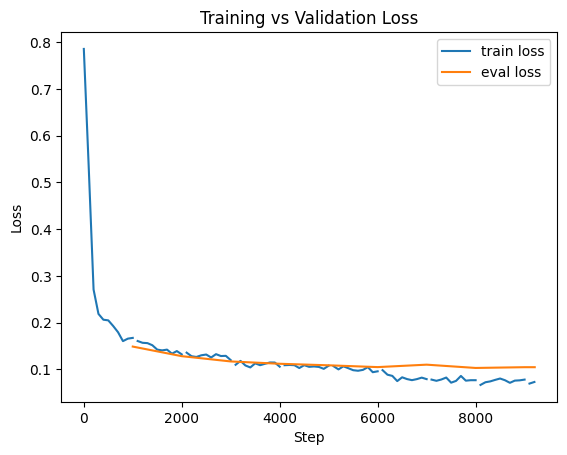

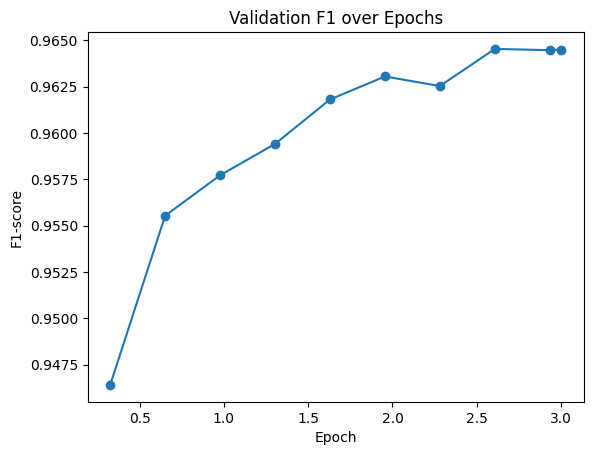

In [ ]:
eval_graph_ALBERT(history)

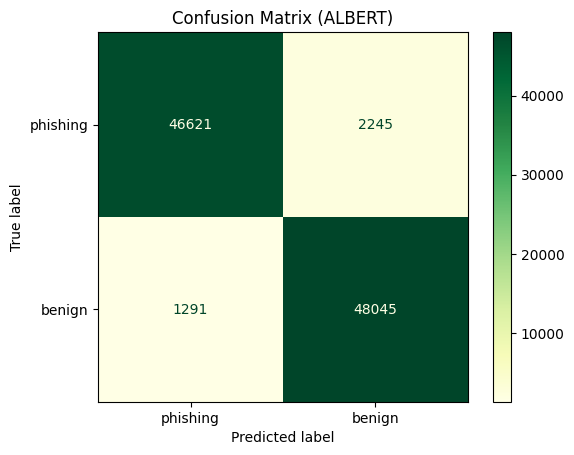

In [ ]:
conf_matrix_ALBERT(y_true, y_pred, label_names=['phishing', 'benign'])

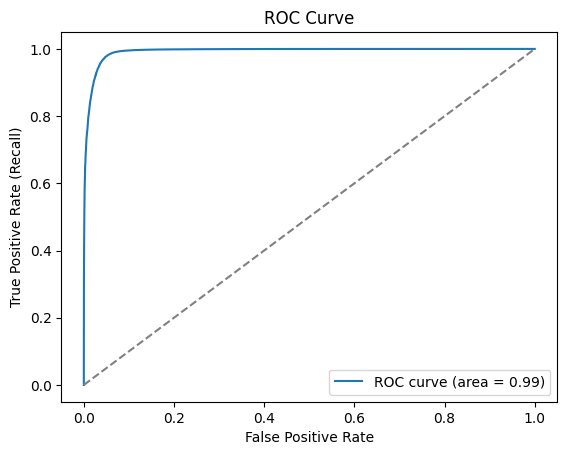

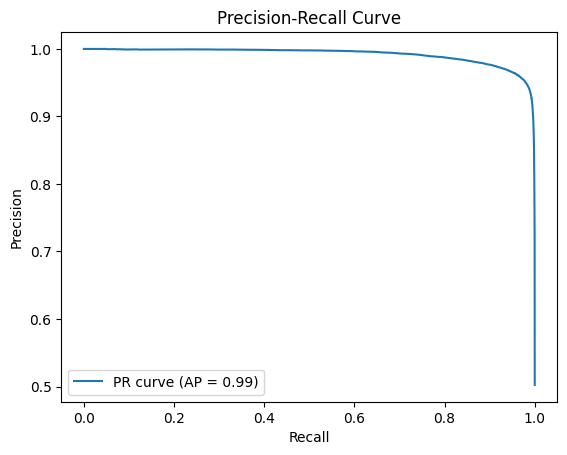

In [ ]:
pr_roc_ALBERT(y_true, y_probs)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Đường dẫn đến model của bạn
model_path = "/content/drive/MyDrive/DeAnTotNghiep/Trained_Models/PhiUSIIL_ALBERT_Tranning_Result/"

# Load tokenizer và model đã fine-tuned
tokenizer = AutoTokenizer.from_pretrained(model_path)
albert = AutoModelForSequenceClassification.from_pretrained(model_path)
albert.eval()  # Chuyển sang chế độ inference (không cần gradient)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
albert.to(device)

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=

In [ ]:
print("\n🔍 Testing inference...")
test_urls = [
    "https://annabellechong.com/",
]

# Tokenize input
inputs = tokenizer(test_urls, truncation=True, padding=True, max_length=128, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

# Dự đoán
with torch.no_grad():
    outputs = albert(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted_labels = torch.argmax(outputs.logits, dim=1)

# In kết quả
print("\nInference Results:")
print("(Dataset labels: 0=Phishing, 1=Legitimate)")
print("-" * 70)
for url, prob, pred_label in zip(test_urls, probs, predicted_labels):
    phishing_prob = prob[0].item()
    legit_prob = prob[1].item()
    label = "🚨 PHISHING" if pred_label == 0 else "✅ LEGITIMATE"
    confidence = phishing_prob if pred_label == 0 else legit_prob

    print(f"  {label} ({confidence:.2%}) | Phish: {phishing_prob:.2%} | Legit: {legit_prob:.2%}")
    print(f"    → {url}")

print("\n✅ All done! Model ready for deployment.")


🔍 Testing inference...

Inference Results:
(Dataset labels: 0=Phishing, 1=Legitimate)
----------------------------------------------------------------------
  ✅ LEGITIMATE (94.81%) | Phish: 5.19% | Legit: 94.81%
    → https://annabellechong.com/

✅ All done! Model ready for deployment.


# ALBERT Explain Using SHAP

In [ ]:
import shap
import torch
import numpy as np
import pandas as pd
import gc
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_from_disk
import pickle

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/DeAnTotNghiep/Trained_Models/PhiUSIIL_ALBERT_Tranning_Result/PhiUSIIL_ALBERT_Best_Model/"
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2", use_fast=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load lại dataset gốc
df = pd.read_csv('/content/drive/MyDrive/DeAnTotNghiep/PhiUSIIL_final_dataset.csv', sep=';')

# Giữ nguyên chia train/test như ban đầu
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Lấy ngẫu nhiên background và sample text
background_size = 3000
sample_size = 10000

background_texts = train_df['url'].sample(background_size, random_state=42).tolist()
sample_texts = test_df['url'].sample(sample_size, random_state=42).tolist()

print(f"📊 Background: {len(background_texts)} | Samples: {len(sample_texts)}")

📊 Background: 3000 | Samples: 10000


In [ ]:
@torch.inference_mode()
def predict_proba(texts):
    # Nếu đầu vào không phải list[str], ép về list[str]
    if not isinstance(texts, list):
        texts = list(texts)
    if len(texts) > 0 and not isinstance(texts[0], str):
        texts = [str(x) for x in texts]

    # Tokenize văn bản
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to("cuda")

    # FP16 inference tăng tốc
    with torch.cuda.amp.autocast():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)

    return probs.detach().cpu().numpy()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")

# Load model lên device phù hợp
model = model.to(device)

@torch.inference_mode()
def predict_proba_auto(texts):
    """
    Tự động sử dụng GPU nếu có, không thì dùng CPU
    """
    if not isinstance(texts, list):
        texts = list(texts)
    if len(texts) > 0 and not isinstance(texts[0], str):
        texts = [str(x) for x in texts]

    # Tokenize và chuyển sang device phù hợp
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

    # Forward pass với mixed precision nếu có GPU
    if device.type == "cuda":
        with torch.cuda.amp.autocast():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    else:
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)

    return probs.detach().cpu().numpy()

🖥️  Using device: cpu


In [ ]:
masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(predict_proba, masker, output_names=["class_0", "class_1"])

In [ ]:
batch_size = 2500
all_shap_values = []
print("⏳ Bắt đầu tính SHAP values...\n")

for i in tqdm(range(0, len(sample_texts), batch_size)):
    batch = sample_texts[i:i+batch_size]

    # Tính SHAP cho batch
    shap_values = explainer(batch)

    all_shap_values.extend(shap_values)
    torch.cuda.empty_cache()
    gc.collect()

    print(f"✅ Done {i+len(batch)}/{len(sample_texts)}")

In [ ]:
with open("/kaggle/working/PhiUSIIL_ALBERT_SHAP_values.pkl", "wb") as f:
    pickle.dump(all_shap_values, f)

summary_data = {
    "text": sample_texts,
    "pred_class": [np.argmax(v.values.mean(0)) for v in all_shap_values],
    "mean_abs_shap": [np.mean(np.abs(v.values)) for v in all_shap_values],
}
pd.DataFrame(summary_data).to_csv("/kaggle/working/PhiUSIIL_ALBERT_SHAP_summary.csv", index=False)

print("\n✅ Lưu thành công shap values & summary!")

In [ ]:
import joblib
all_shap_values = joblib.load("/content/drive/MyDrive/DeAnTotNghiep/Explain_Models/PhiUSIIL_ALBERT_SHAP/PhiUSIIL_ALBERT_SHAP_values.pkl")

In [ ]:
def prepare_shap_with_aggregated_tokens(shap_values_list, top_k_tokens=50):
    """
    Aggregate SHAP values theo các tokens phổ biến nhất
    Tạo features có tên có ý nghĩa thay vì "token_0", "token_1"
    """
    # Bước 1: Tìm top_k tokens xuất hiện nhiều nhất
    token_counts = {}
    for shap_val in shap_values_list:
        for token in shap_val.data:
            token = str(token).strip()
            if token and token not in ['[CLS]', '[SEP]', '[PAD]']:
                token_counts[token] = token_counts.get(token, 0) + 1

    # Lấy top_k tokens
    top_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)[:top_k_tokens]
    top_token_list = [t[0] for t in top_tokens]
    token_to_idx = {token: idx for idx, token in enumerate(top_token_list)}

    print(f"📊 Top {top_k_tokens} most frequent tokens:")
    for i, (token, count) in enumerate(top_tokens[:10], 1):
        print(f"  {i:2d}. '{token}' ({count} occurrences)")

    # Bước 2: Tạo ma trận SHAP values cho các tokens này
    n_samples = len(shap_values_list)
    shap_matrix = np.zeros((n_samples, top_k_tokens))
    data_matrix = np.zeros((n_samples, top_k_tokens))  # 1 nếu token xuất hiện, 0 nếu không

    for i, shap_val in enumerate(shap_values_list):
        values = shap_val.values[:, 1] if len(shap_val.values.shape) > 1 else shap_val.values
        tokens = shap_val.data

        for token, value in zip(tokens, values):
            token = str(token).strip()
            if token in token_to_idx:
                idx = token_to_idx[token]
                shap_matrix[i, idx] += value  # Cộng dồn nếu token xuất hiện nhiều lần
                data_matrix[i, idx] = 1  # Đánh dấu token có xuất hiện

    return shap_matrix, data_matrix, top_token_list

In [ ]:
print("\n🔄 Đang tạo bee swarm plot với token names...")
shap_matrix_agg, data_matrix_agg, feature_names = prepare_shap_with_aggregated_tokens(
    all_shap_values,
    top_k_tokens=30
)


🔄 Đang tạo bee swarm plot với token names...
📊 Top 30 most frequent tokens:
   1. '.' (20124 occurrences)
   2. 's' (13027 occurrences)
   3. 'http' (10100 occurrences)
   4. '://' (10065 occurrences)
   5. '/' (9263 occurrences)
   6. 'com' (5831 occurrences)
   7. '-' (5202 occurrences)
   8. 'www' (3859 occurrences)
   9. 'd' (1661 occurrences)
  10. '=' (1408 occurrences)


In [ ]:
shap_explanation_agg = shap.Explanation(
    values=shap_matrix_agg,
    data=data_matrix_agg,
    feature_names=feature_names
)

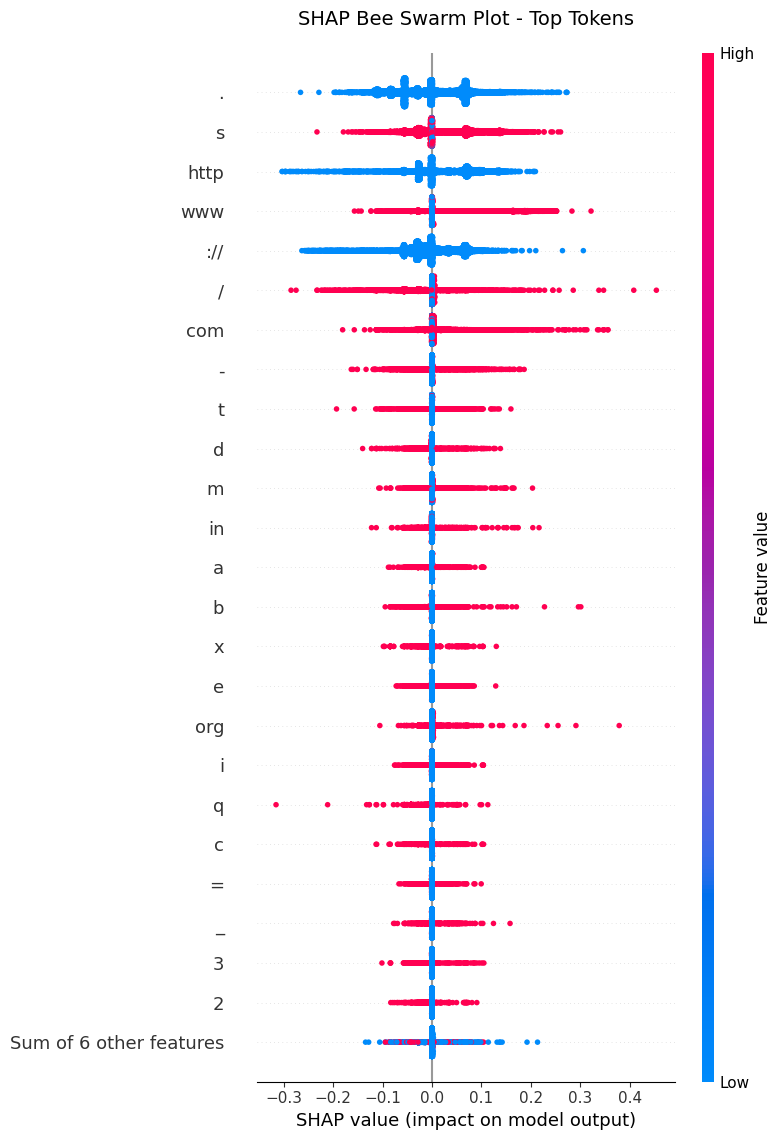

In [ ]:
plt.figure(figsize=(10, 10))
shap.plots.beeswarm(shap_explanation_agg, max_display=25, show=False)
plt.title("SHAP Bee Swarm Plot - Top Tokens", fontsize=14, pad=20)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/DeAnTotNghiep/Explain_Models/PhiUSIIL_ALBERT_SHAP/shap_beeswarm_tokens.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

sample_idx = 42
sample_text = sample_texts[sample_idx]
sample_shap = all_shap_values[sample_idx]

sample_probs = predict_proba_auto([sample_text])[0]
print(f"Class 0 (Phishing): {sample_probs[0]:.6f}")  # ~0.000031
print(f"Class 1 (Benign):   {sample_probs[1]:.6f}")  # ~0.999969

Class 0 (Phishing): 0.001480
Class 1 (Benign):   0.998520


In [ ]:


shap.plots.text(sample_shap)

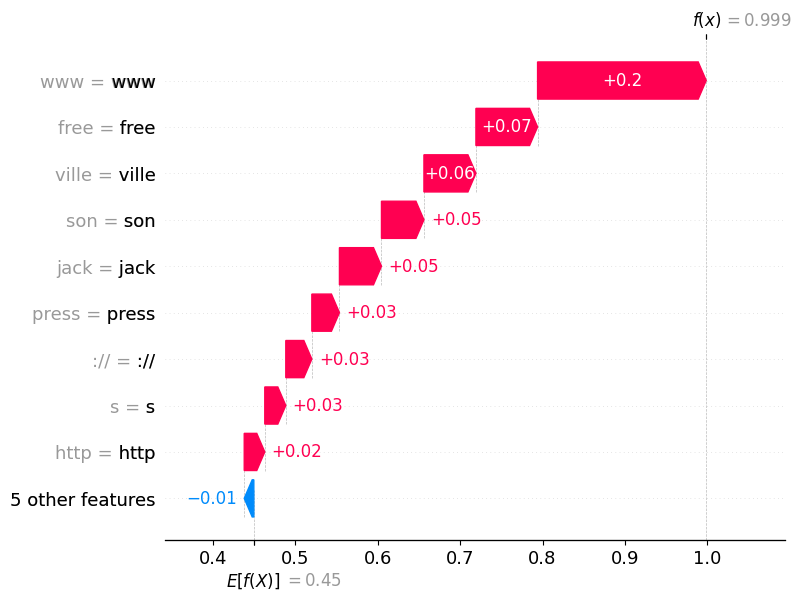

In [ ]:
shap.plots.waterfall(sample_shap[:, 1])


📊 TOP CONTRIBUTING TOKENS:


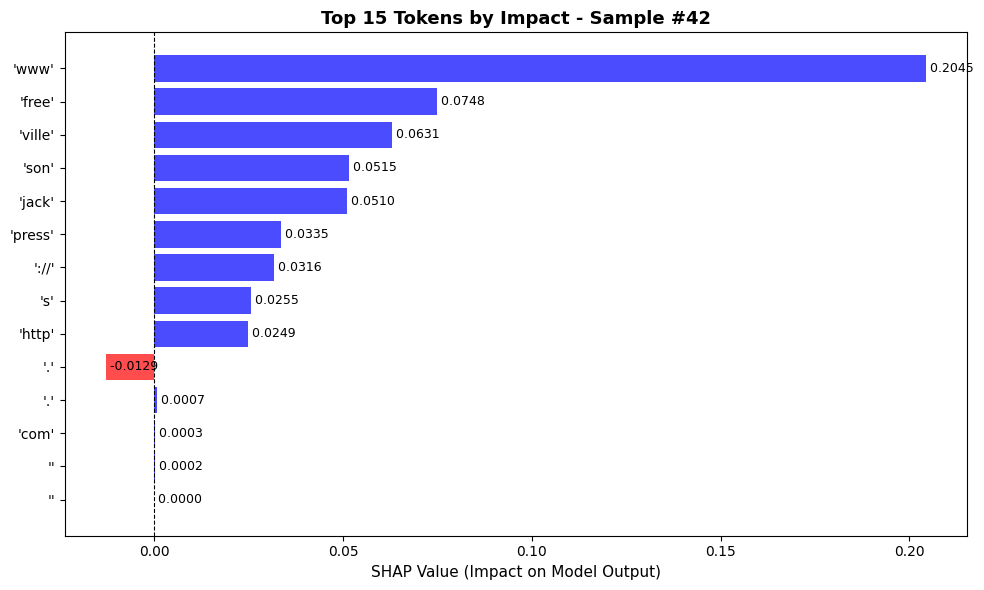

In [ ]:
def plot_top_tokens_bar(shap_values, data, class_idx=1, top_n=15):
    """Vẽ bar plot cho top tokens có impact lớn nhất"""
    values = shap_values[:, class_idx]
    tokens = data

    # Lấy top tokens (both positive and negative)
    abs_values = np.abs(values)
    top_indices = np.argsort(abs_values)[-top_n:][::-1]

    top_tokens = [tokens[i] for i in top_indices]
    top_values = [values[i] for i in top_indices]

    # Vẽ
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['red' if v < 0 else 'blue' for v in top_values]
    bars = ax.barh(range(len(top_tokens)), top_values, color=colors, alpha=0.7)

    ax.set_yticks(range(len(top_tokens)))
    ax.set_yticklabels([f"'{t}'" for t in top_tokens])
    ax.set_xlabel('SHAP Value (Impact on Model Output)', fontsize=11)
    ax.set_title(f'Top {top_n} Tokens by Impact - Sample #{sample_idx}',
                 fontsize=13, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    ax.invert_yaxis()

    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, top_values)):
        ax.text(val, i, f' {val:.4f}', va='center', fontsize=9)

    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/DeAnTotNghiep/Explain_Models/PhiUSIIL_ALBERT_SHAP/sample_{sample_idx}_bar.png", dpi=300, bbox_inches='tight')
    plt.show()

    return top_tokens, top_values

print("\n📊 TOP CONTRIBUTING TOKENS:")
top_tokens, top_values = plot_top_tokens_bar(sample_shap.values, sample_shap.data,
                                              class_idx=1, top_n=15)

In [ ]:
def create_token_analysis_table(shap_values, data, class_idx=1):
    """Tạo bảng phân tích chi tiết từng token"""
    import pandas as pd

    values = shap_values[:, class_idx]
    tokens = data

    # Tạo DataFrame
    analysis_data = []
    for i, (token, value) in enumerate(zip(tokens, values)):
        if token.strip() and token not in ['[PAD]', '[CLS]', '[SEP]']:
            analysis_data.append({
                'Position': i,
                'Token': token,
                'SHAP Value': value,
                'Abs SHAP': abs(value),
                'Impact': 'Push to Benign' if class_idx == 1 else 'Push to Phishing',
                'Strength': '🔴 Strong' if abs(value) > 0.05 else
                           '🟡 Medium' if abs(value) > 0.02 else '🟢 Weak'
            })

    df = pd.DataFrame(analysis_data)
    df = df.sort_values('Abs SHAP', ascending=False)

    return df

print("\n📋 DETAILED TOKEN ANALYSIS TABLE:")
token_df = create_token_analysis_table(sample_shap.values, sample_shap.data, class_idx=1)
print(token_df.head(20).to_string(index=False))

# Lưu full table
token_df.to_csv(f"/content/drive/MyDrive/DeAnTotNghiep/Explain_Models/PhiUSIIL_ALBERT_SHAP/sample_{sample_idx}_token_analysis.csv", index=False)


📋 DETAILED TOKEN ANALYSIS TABLE:
 Position Token  SHAP Value  Abs SHAP         Impact Strength
        4   www    0.204548  0.204548 Push to Benign 🔴 Strong
        9  free    0.074774  0.074774 Push to Benign 🔴 Strong
        8 ville    0.063056  0.063056 Push to Benign 🔴 Strong
        7   son    0.051504  0.051504 Push to Benign 🔴 Strong
        6  jack    0.050990  0.050990 Push to Benign 🔴 Strong
       10 press    0.033465  0.033465 Push to Benign 🟡 Medium
        3   ://    0.031590  0.031590 Push to Benign 🟡 Medium
        2     s    0.025497  0.025497 Push to Benign 🟡 Medium
        1  http    0.024933  0.024933 Push to Benign 🟡 Medium
        5     .   -0.012888  0.012888 Push to Benign   🟢 Weak
       11     .    0.000670  0.000670 Push to Benign   🟢 Weak
       12   com    0.000291  0.000291 Push to Benign   🟢 Weak



📈 CUMULATIVE IMPACT PLOT:


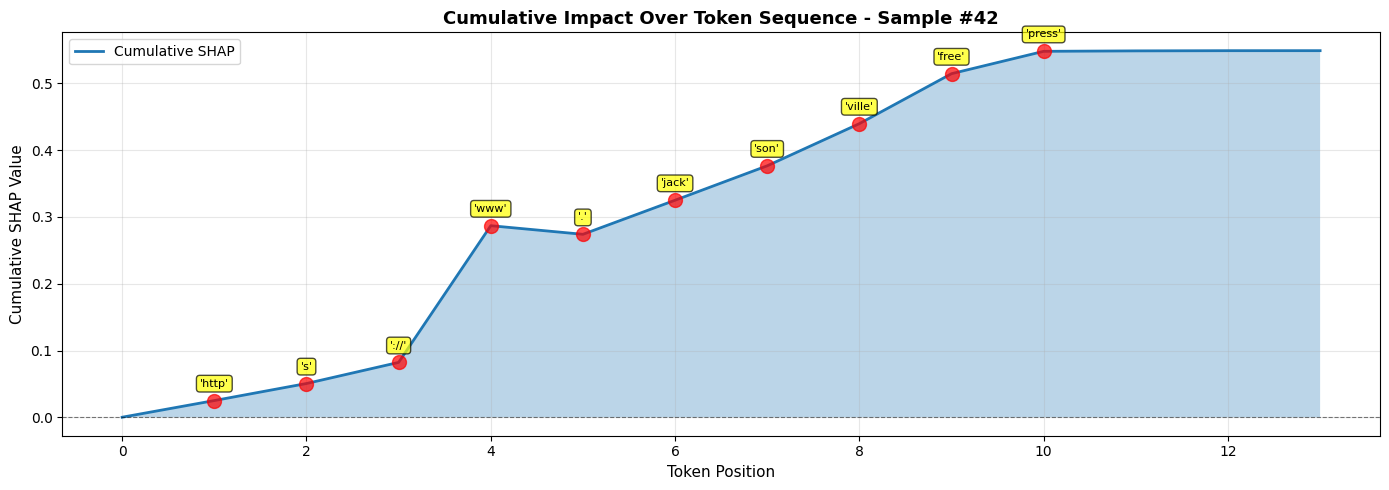

In [ ]:
def plot_cumulative_impact(shap_values, data, class_idx=1):
    """Vẽ cumulative SHAP values theo position"""
    values = shap_values[:, class_idx]

    # Tính cumulative sum
    cumsum = np.cumsum(values)
    base_value = sample_shap.base_values[class_idx]

    fig, ax = plt.subplots(figsize=(14, 5))

    # Plot cumulative impact
    ax.plot(cumsum, linewidth=2, label='Cumulative SHAP')
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.fill_between(range(len(cumsum)), cumsum, 0, alpha=0.3)

    # Highlight important tokens
    abs_values = np.abs(values)
    top_indices = np.argsort(abs_values)[-10:]

    for idx in top_indices:
        if data[idx].strip():
            ax.scatter(idx, cumsum[idx], s=100, c='red', zorder=5, alpha=0.7)
            ax.annotate(f"'{data[idx]}'",
                       xy=(idx, cumsum[idx]),
                       xytext=(0, 10),
                       textcoords='offset points',
                       ha='center',
                       fontsize=8,
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

    ax.set_xlabel('Token Position', fontsize=11)
    ax.set_ylabel('Cumulative SHAP Value', fontsize=11)
    ax.set_title(f'Cumulative Impact Over Token Sequence - Sample #{sample_idx}',
                 fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/DeAnTotNghiep/Explain_Models/PhiUSIIL_ALBERT_SHAP/sample_{sample_idx}_cumulative.png", dpi=300, bbox_inches='tight')
    plt.show()

print("\n📈 CUMULATIVE IMPACT PLOT:")
plot_cumulative_impact(sample_shap.values, sample_shap.data, class_idx=1)


🔥 HEATMAP - Both Classes Comparison:


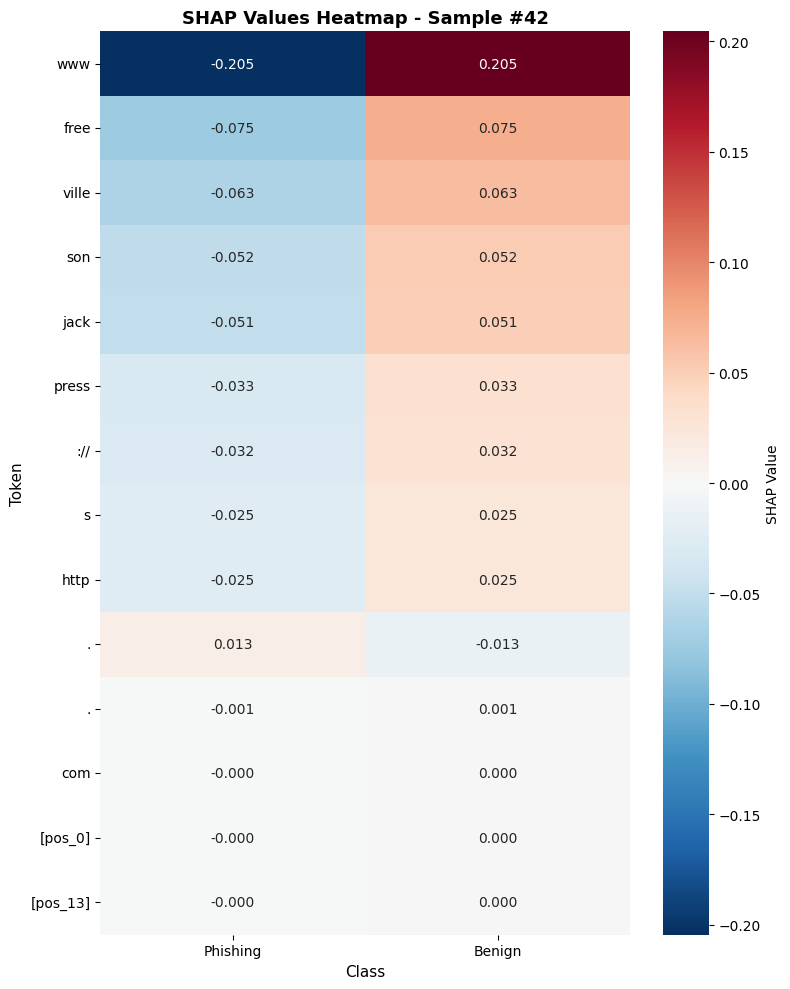

In [ ]:
def plot_shap_heatmap(shap_values, data, top_n=20):
    """Heatmap so sánh SHAP values giữa 2 classes"""
    # Lấy top tokens theo abs value trung bình
    mean_abs_shap = np.abs(shap_values).mean(axis=1)
    top_indices = np.argsort(mean_abs_shap)[-top_n:][::-1]

    # Tạo ma trận 2 cột (class 0, class 1)
    heatmap_data = shap_values[top_indices, :]
    token_labels = [data[i] if data[i].strip() else f"[pos_{i}]" for i in top_indices]

    fig, ax = plt.subplots(figsize=(8, 10))
    sns.heatmap(heatmap_data,
                annot=True,
                fmt='.3f',
                cmap='RdBu_r',
                center=0,
                cbar_kws={'label': 'SHAP Value'},
                yticklabels=token_labels,
                xticklabels=['Phishing', 'Benign'],
                ax=ax)

    ax.set_title(f'SHAP Values Heatmap - Sample #{sample_idx}',
                 fontsize=13, fontweight='bold')
    ax.set_xlabel('Class', fontsize=11)
    ax.set_ylabel('Token', fontsize=11)

    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/DeAnTotNghiep/Explain_Models/PhiUSIIL_ALBERT_SHAP/sample_{sample_idx}_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()

print("\n🔥 HEATMAP - Both Classes Comparison:")
plot_shap_heatmap(sample_shap.values, sample_shap.data, top_n=20)


🛣️ DECISION PLOT - Path from base value to prediction:


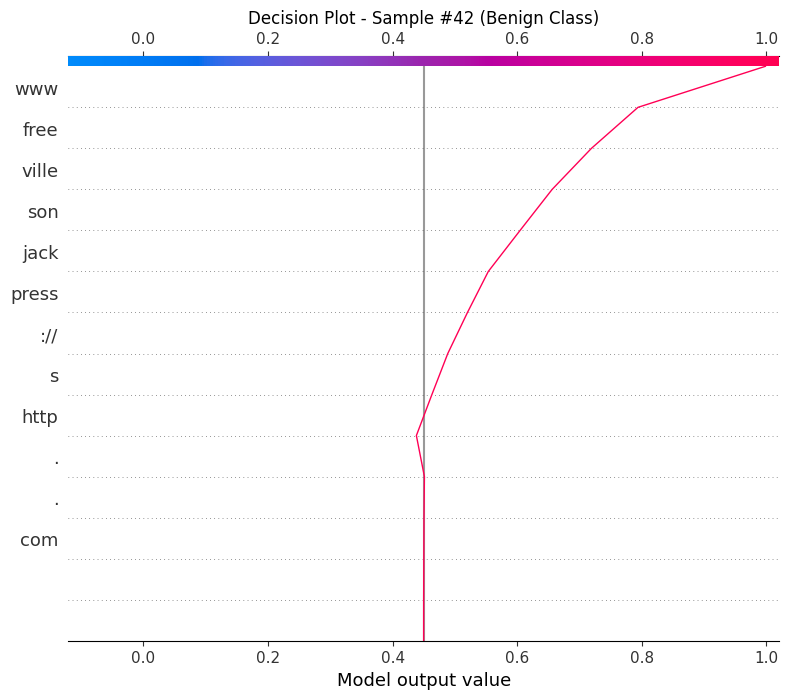

In [ ]:
print("\n🛣️ DECISION PLOT - Path from base value to prediction:")

# Decision plot cho benign class (class 1)
shap.decision_plot(
    sample_shap.base_values[1],
    sample_shap.values[:, 1],
    sample_shap.data,
    feature_display_range=slice(-1, -21, -1),  # Top 20 features
    show=False
)
plt.title(f"Decision Plot - Sample #{sample_idx} (Benign Class)", fontsize=12)
plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/DeAnTotNghiep/Explain_Models/PhiUSIIL_ALBERT_SHAP/sample_{sample_idx}_decision.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

sample_idx = 125
sample_text = sample_texts[sample_idx]
sample_shap = all_shap_values[sample_idx]

sample_probs = predict_proba_auto([sample_text])[0]
print(f"Class 0 (Phishing): {sample_probs[0]:.6f}")  # ~0.000031
print(f"Class 1 (Benign):   {sample_probs[1]:.6f}")  # ~0.999969

Class 0 (Phishing): 0.999902
Class 1 (Benign):   0.000098


In [ ]:
shap.plots.text(sample_shap)

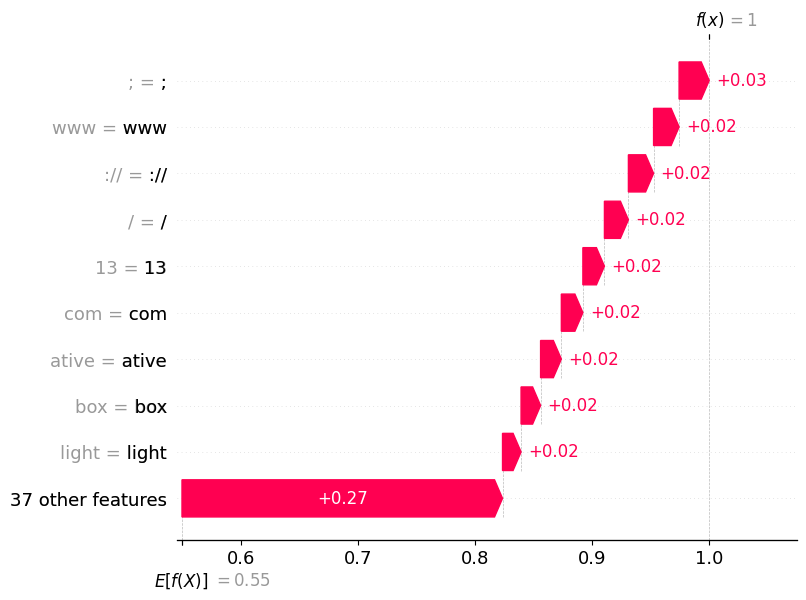

In [ ]:
shap.plots.waterfall(sample_shap[:, 0])


📊 TOP CONTRIBUTING TOKENS:


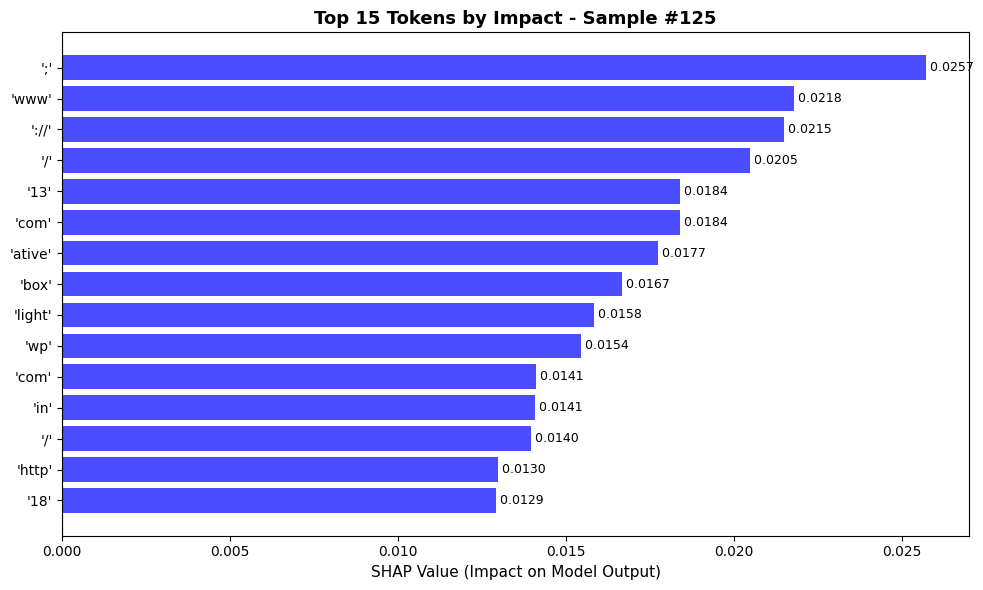

In [ ]:
print("\n📊 TOP CONTRIBUTING TOKENS:")
top_tokens, top_values = plot_top_tokens_bar(sample_shap.values, sample_shap.data,
                                              class_idx=0, top_n=15)

In [ ]:
print("\n📋 DETAILED TOKEN ANALYSIS TABLE:")
token_df = create_token_analysis_table(sample_shap.values, sample_shap.data, class_idx=0)
print(token_df.head(20).to_string(index=False))

# Lưu full table
token_df.to_csv(f"/content/drive/MyDrive/DeAnTotNghiep/Explain_Models/PhiUSIIL_ALBERT_SHAP/sample_{sample_idx}_token_analysis.csv", index=False)


📋 DETAILED TOKEN ANALYSIS TABLE:
 Position Token  SHAP Value  Abs SHAP           Impact Strength
       44     ;    0.025707  0.025707 Push to Phishing 🟡 Medium
        3   www    0.021775  0.021775 Push to Phishing 🟡 Medium
        2   ://    0.021488  0.021488 Push to Phishing 🟡 Medium
       18     /    0.020466  0.020466 Push to Phishing 🟡 Medium
       29    13    0.018388  0.018388 Push to Phishing   🟢 Weak
        7   com    0.018384  0.018384 Push to Phishing   🟢 Weak
        6 ative    0.017720  0.017720 Push to Phishing   🟢 Weak
       31   box    0.016664  0.016664 Push to Phishing   🟢 Weak
       32 light    0.015825  0.015825 Push to Phishing   🟢 Weak
       12    wp    0.015446  0.015446 Push to Phishing   🟢 Weak
       10   com    0.014092  0.014092 Push to Phishing   🟢 Weak
       30    in    0.014061  0.014061 Push to Phishing   🟢 Weak
       11     /    0.013953  0.013953 Push to Phishing   🟢 Weak
        1  http    0.012971  0.012971 Push to Phishing   🟢 Weak
      


🔥 HEATMAP - Both Classes Comparison:


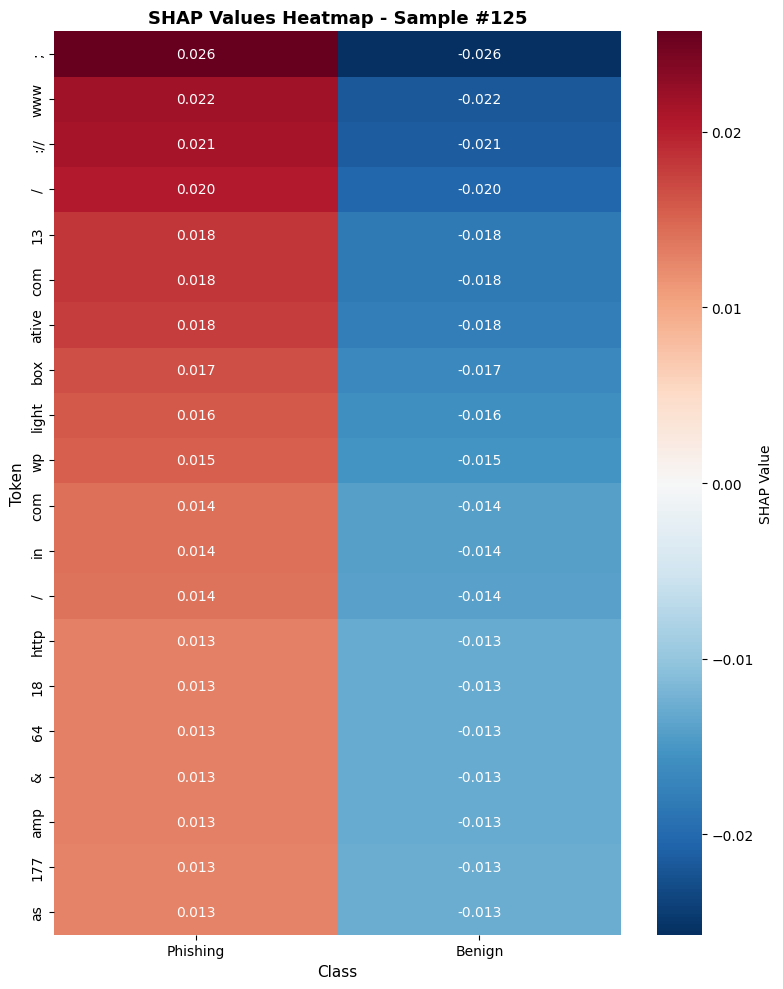

In [ ]:
print("\n🔥 HEATMAP - Both Classes Comparison:")
plot_shap_heatmap(sample_shap.values, sample_shap.data, top_n=20)


📈 CUMULATIVE IMPACT PLOT:


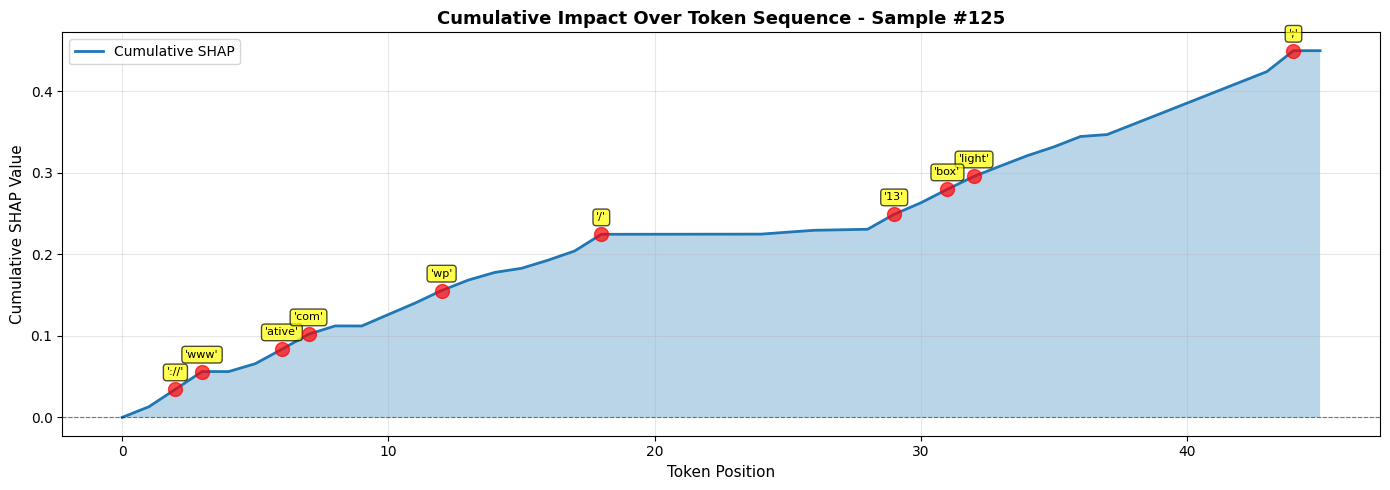

In [ ]:
print("\n📈 CUMULATIVE IMPACT PLOT:")
plot_cumulative_impact(sample_shap.values, sample_shap.data, class_idx=0)


🛣️ DECISION PLOT - Path from base value to prediction:


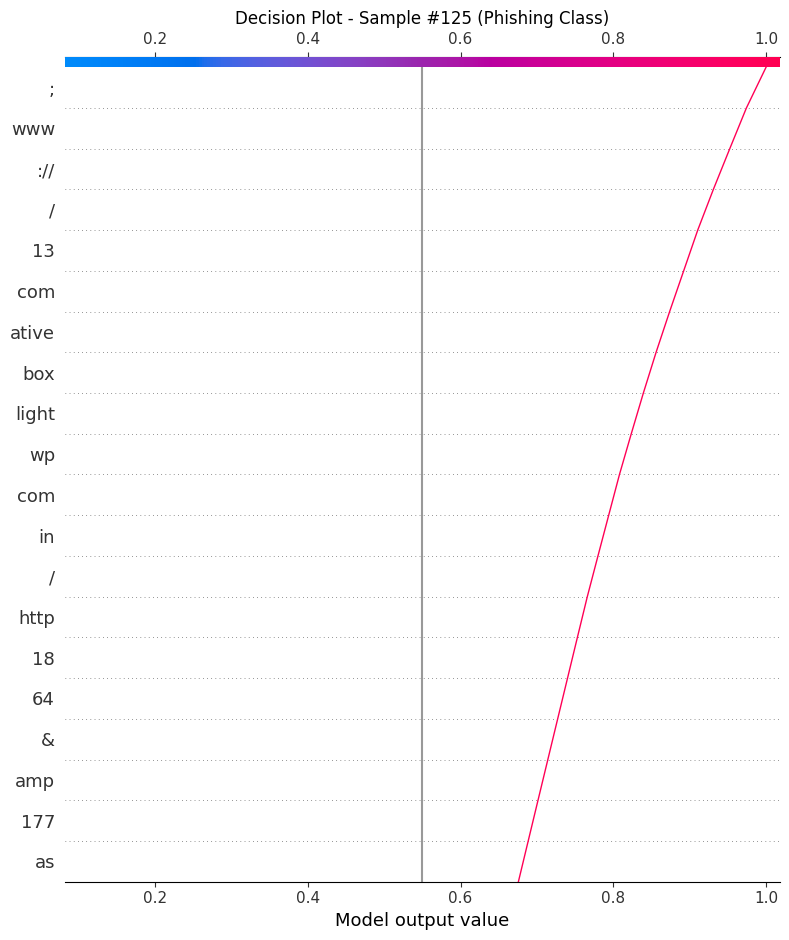

In [ ]:
print("\n🛣️ DECISION PLOT - Path from base value to prediction:")

# Decision plot cho benign class (class 0)
shap.decision_plot(
    sample_shap.base_values[0],
    sample_shap.values[:, 0],
    sample_shap.data,
    feature_display_range=slice(-1, -21, -1),  # Top 20 features
    show=False
)
plt.title(f"Decision Plot - Sample #{sample_idx} (Phishing Class)", fontsize=12)
plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/DeAnTotNghiep/Explain_Models/PhiUSIIL_ALBERT_SHAP/sample_{sample_idx}_decision.png", dpi=300, bbox_inches='tight')
plt.show()

# Prepare Train/Test for Mobile-BERT (URL Tokenizer Only)

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/DeAnTotNghiep/PhiUSIIL_final_dataset.csv', sep=';')
# df.head(10)

,url,label
0,https://google.com,1
1,https://facebook.com,1
2,https://youtube.com,1
3,https://baidu.com,1
4,https://yahoo.com,1
5,https://amazon.com,1
6,https://wikipedia.org,1
7,https://qq.com,1
8,https://twitter.com,1
9,https://google.co.in,1


In [59]:
df.head(10)

,url,label
0,https://google.com,1
1,https://facebook.com,1
2,https://youtube.com,1
3,https://baidu.com,1
4,https://yahoo.com,1
5,https://amazon.com,1
6,https://wikipedia.org,1
7,https://qq.com,1
8,https://twitter.com,1
9,https://google.co.in,1


In [45]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [46]:
from datasets import Dataset
X_train6 = Dataset.from_pandas(train_df)
X_test6 = Dataset.from_pandas(test_df)

print("Train shape:", X_train6.shape, "Test shape:", X_test6.shape)
print("\nOriginal dataset class distribution:")
print(df['label'].value_counts(normalize=True))
print("\nTraining set class distribution:")
print(train_df['label'].value_counts(normalize=True))
print("\nTest set class distribution:")
print(test_df['label'].value_counts(normalize=True))

Train shape: (389635, 2) Test shape: (97409, 2)

Original dataset class distribution:
label
1    0.50781
0    0.49219
Name: proportion, dtype: float64

Training set class distribution:
label
1    0.507811
0    0.492189
Name: proportion, dtype: float64

Test set class distribution:
label
1    0.507807
0    0.492193
Name: proportion, dtype: float64


In [47]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("google/mobilebert-uncased", use_fast=True)

print(tokenizer("https://account.microsoft.com/account"))

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

{'input_ids': [101, 16770, 1024, 1013, 1013, 4070, 1012, 7513, 1012, 4012, 1013, 4070, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [48]:
def preprocess(batch):
    urls = [u.strip() for u in batch["url"]]
    return tokenizer(urls, truncation=True, padding="max_length", max_length=128)

In [49]:
X_train6 = X_train6.map(preprocess, batched=True, remove_columns=["url"])
X_test6 = X_test6.map(preprocess, batched=True, remove_columns=["url"])

Map:   0%|          | 0/389635 [00:00<?, ? examples/s]

Map:   0%|          | 0/97409 [00:00<?, ? examples/s]

In [50]:
X_train6.save_to_disk("/content/drive/MyDrive/DeAnTotNghiep/X_train6")
X_test6.save_to_disk("/content/drive/MyDrive/DeAnTotNghiep/X_test6")

Saving the dataset (0/1 shards):   0%|          | 0/389635 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/97409 [00:00<?, ? examples/s]

In [51]:
!zip -r /content/drive/MyDrive/DeAnTotNghiep/X_train6.zip /content/drive/MyDrive/DeAnTotNghiep/X_train6
!zip -r /content/drive/MyDrive/DeAnTotNghiep/X_test6.zip /content/drive/MyDrive/DeAnTotNghiep/X_test6

  adding: content/drive/MyDrive/DeAnTotNghiep/X_train6/ (stored 0%)
  adding: content/drive/MyDrive/DeAnTotNghiep/X_train6/data-00000-of-00001.arrow (deflated 95%)
  adding: content/drive/MyDrive/DeAnTotNghiep/X_train6/state.json (deflated 38%)
  adding: content/drive/MyDrive/DeAnTotNghiep/X_train6/dataset_info.json (deflated 70%)
  adding: content/drive/MyDrive/DeAnTotNghiep/X_test6/ (stored 0%)
  adding: content/drive/MyDrive/DeAnTotNghiep/X_test6/data-00000-of-00001.arrow (deflated 95%)
  adding: content/drive/MyDrive/DeAnTotNghiep/X_test6/state.json (deflated 38%)
  adding: content/drive/MyDrive/DeAnTotNghiep/X_test6/dataset_info.json (deflated 70%)


In [52]:
from datasets import load_from_disk
X_train6 = load_from_disk("/content/drive/MyDrive/DeAnTotNghiep/X_train6")
X_test6 = load_from_disk("/content/drive/MyDrive/DeAnTotNghiep/X_test6")

In [53]:
X_train6.set_format(type="torch", columns=["input_ids","attention_mask","label"])
X_test6.set_format(type="torch", columns=["input_ids","attention_mask","label"])

In [54]:
print(X_train6[:1])

{'label': tensor([1]), 'input_ids': tensor([[  101, 16770,  1024,  1013,  1013,  7479,  1012,  1062,  2953,  7690,
          1012,  5658,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0, 

# Tranning & Evaluation Mobile-BERT With URL Tokenizer

In [55]:
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding='longest',  # Dynamic padding - hiệu quả hơn
)

In [56]:
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=5,  # Dừng nếu không cải thiện sau 3 eval
    early_stopping_threshold=0.0005  # Threshold để coi là "cải thiện"
)

In [57]:
trainer = Trainer(
    model=albert_model,
    args=training_args,
    train_dataset=X_train6,
    eval_dataset=X_test6,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],  # Thêm early stopping
)

In [62]:
print("\n" + "="*60)
print("🚀 STARTING TRAINING ON KAGGLE T4 GPU")
print("="*60)
print(f"📊 Train samples: {len(X_train6)}")
print(f"📊 Test samples: {len(X_test6)}")
print(f"⚙️  Effective batch size: {BATCH_SIZE * ACCUM_STEPS}")
print(f"⚙️  Total steps: {len(X_train6) // (BATCH_SIZE * ACCUM_STEPS) * NUM_EPOCHS}")
print(f"⏱️  Estimated time: ~{len(X_train6) // (BATCH_SIZE * ACCUM_STEPS) * NUM_EPOCHS * 0.5 / 60:.1f} minutes")
print("="*60 + "\n")

# Train model
train_result = trainer.train()


🚀 STARTING TRAINING ON KAGGLE T4 GPU
📊 Train samples: 389635
📊 Test samples: 97409
⚙️  Effective batch size: 64
⚙️  Total steps: 18264
⏱️  Estimated time: ~152.2 minutes



Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
print("\n💾 Saving best model...")
trainer.save_model("/kaggle/working/PhiUSIIL_MobileBERT_Best_Model")
tokenizer.save_pretrained("/kaggle/working/PhiUSIIL_MobileBERT_Best_Model")


💾 Saving best model...


('/kaggle/working/PhiUSIIL_MobileBERT_Best_Model/tokenizer_config.json',
 '/kaggle/working/PhiUSIIL_MobileBERT_Best_Model/special_tokens_map.json',
 '/kaggle/working/PhiUSIIL_MobileBERT_Best_Model/vocab.txt',
 '/kaggle/working/PhiUSIIL_MobileBERT_Best_Model/added_tokens.json',
 '/kaggle/working/PhiUSIIL_MobileBERT_Best_Model/tokenizer.json')

In [ ]:
print("\n" + "="*60)
print("📊 FINAL EVALUATION ON TEST SET")
print("="*60)

eval_results = trainer.evaluate()
for key, value in sorted(eval_results.items()):
    if isinstance(value, float):
        print(f"  {key:20s}: {value:.4f}")
    else:
        print(f"  {key:20s}: {value}")


📊 FINAL EVALUATION ON TEST SET


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


  epoch               : 3.0000
  eval_accuracy       : 0.9632
  eval_f1             : 0.9640
  eval_loss           : nan
  eval_pr_auc         : 0.0000
  eval_precision      : 0.9482
  eval_recall         : 0.9804
  eval_roc_auc        : 0.0000
  eval_runtime        : 69.3610
  eval_samples_per_second: 1415.8110
  eval_steps_per_second: 2.7680


In [ ]:
print("\n" + "="*60)
print("✅ TRAINING COMPLETED")
print("="*60)
print(f"⏱️  Total training time: {train_result.metrics['train_runtime']:.2f}s")
print(f"⚡ Samples/second: {train_result.metrics['train_samples_per_second']:.2f}")
print(f"📈 Best PR-AUC: {max([m.get('eval_pr_auc', 0) for m in trainer.state.log_history]):.4f}")
print("="*60)


✅ TRAINING COMPLETED
⏱️  Total training time: 5846.04s
⚡ Samples/second: 201.58
📈 Best PR-AUC: 0.9923


In [ ]:
import pandas as pd
import json

# Lưu log history
log_df = pd.DataFrame(trainer.state.log_history)
log_df.to_csv("/kaggle/working/training_history.csv", index=False)

# Lưu final metrics
with open("/kaggle/working/final_metrics.json", "w") as f:
    json.dump(eval_results, f, indent=2)

print("📁 Files saved:")
print("  - /kaggle/working/PhiUSIIL_MobileBERT_Best_Model/ (model)")
print("  - /kaggle/working/training_history.csv")
print("  - /kaggle/working/final_metrics.json")

📁 Files saved:
  - /kaggle/working/PhiUSIIL_MobileBERT_Best_Model/ (model)
  - /kaggle/working/training_history.csv
  - /kaggle/working/final_metrics.json


In [ ]:
# Thêm cell mới ở cuối notebook và chạy
!zip -r /kaggle/working/PhiUSIIL_ALBERT_TRANNING_RESULT.zip \
    /kaggle/working/PhiUSIIL_MobileBERT_Best_Model \
    /kaggle/working/PhiUSIIL_MobileBERT_Checkpoints \
    /kaggle/working/training_history.csv \
    /kaggle/working/final_metrics.json

print("✅ Created: PhiUSIIL_ALBERT_TRANNING_RESULT.zip")
print("📁 Location: /kaggle/working/PhiUSIIL_ALBERT_TRANNING_RESULT.zip")
print("📊 Now download from Output panel →")

updating: kaggle/working/training_history.csv (deflated 60%)
updating: kaggle/working/final_metrics.json (deflated 45%)
  adding: kaggle/working/PhiUSIIL_MobileBERT_Best_Model/ (stored 0%)
  adding: kaggle/working/PhiUSIIL_MobileBERT_Best_Model/model.safetensors (deflated 7%)
  adding: kaggle/working/PhiUSIIL_MobileBERT_Best_Model/vocab.txt (deflated 53%)
  adding: kaggle/working/PhiUSIIL_MobileBERT_Best_Model/special_tokens_map.json (deflated 42%)
  adding: kaggle/working/PhiUSIIL_MobileBERT_Best_Model/training_args.bin (deflated 51%)
  adding: kaggle/working/PhiUSIIL_MobileBERT_Best_Model/config.json (deflated 54%)
  adding: kaggle/working/PhiUSIIL_MobileBERT_Best_Model/tokenizer.json (deflated 71%)
  adding: kaggle/working/PhiUSIIL_MobileBERT_Best_Model/tokenizer_config.json (deflated 74%)
  adding: kaggle/working/PhiUSIIL_MobileBERT_Checkpoints/ (stored 0%)
  adding: kaggle/working/PhiUSIIL_MobileBERT_Checkpoints/checkpoint-4000/ (stored 0%)
  adding: kaggle/working/PhiUSIIL_Mobile

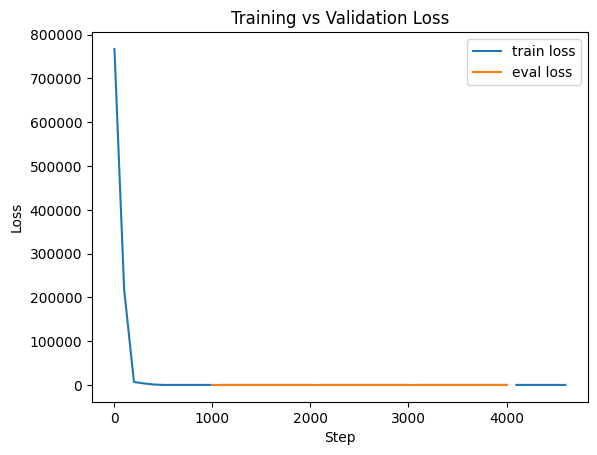

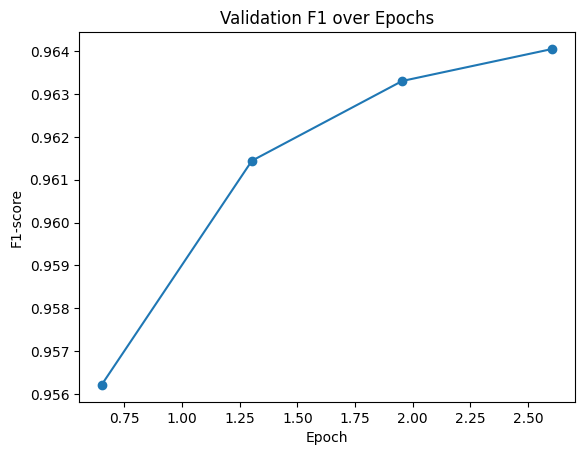

In [ ]:
eval_graph_ALBERT(history)

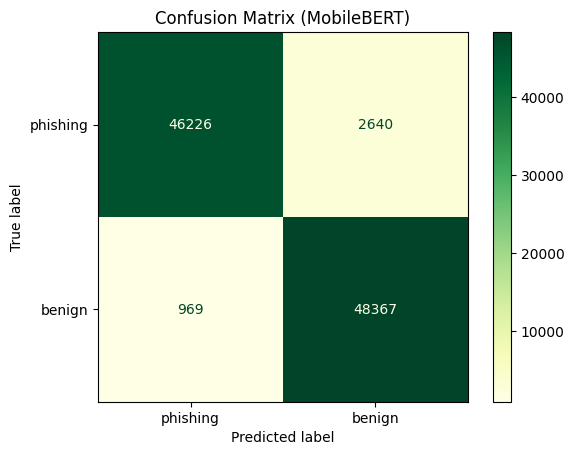

In [ ]:
conf_matrix_ALBERT(y_true, y_pred, label_names=['phishing', 'benign'])

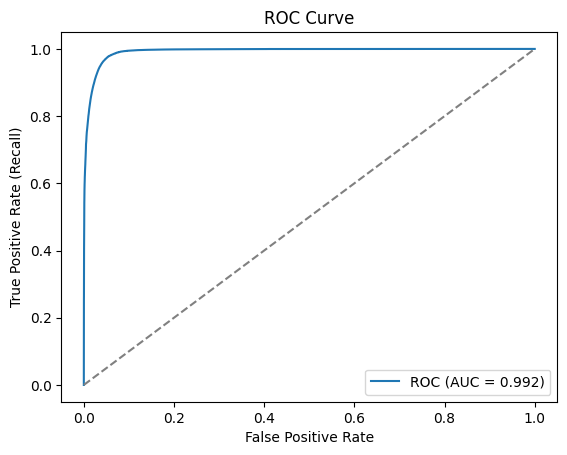

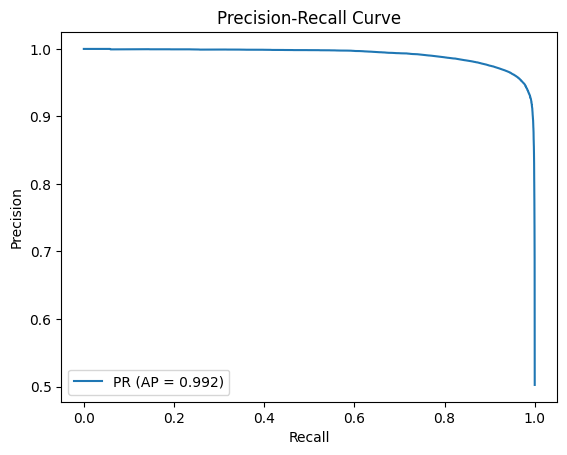

In [ ]:
pr_roc_BERT(y_true, y_probs)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Đường dẫn đến model của bạn
model_path = "/content/drive/MyDrive/DeAnTotNghiep/Trained_Models/PhiUSIIL_MobileBERT_Tranning_Result/"

# Load tokenizer và model đã fine-tuned
tokenizer = AutoTokenizer.from_pretrained(model_path)
mobile-bert = AutoModelForSequenceClassification.from_pretrained(model_path)
mobile-bert.eval()  # Chuyển sang chế độ inference (không cần gradient)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobile-bert.to(device)

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=

In [ ]:
print("\n🔍 Testing inference...")
test_urls = [
    "https://annabellechong.com/",
]

# Tokenize input
inputs = tokenizer(test_urls, truncation=True, padding=True, max_length=128, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

# Dự đoán
with torch.no_grad():
    outputs = mobile-bert(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted_labels = torch.argmax(outputs.logits, dim=1)

# In kết quả
print("\nInference Results:")
print("(Dataset labels: 0=Phishing, 1=Legitimate)")
print("-" * 70)
for url, prob, pred_label in zip(test_urls, probs, predicted_labels):
    phishing_prob = prob[0].item()
    legit_prob = prob[1].item()
    label = "🚨 PHISHING" if pred_label == 0 else "✅ LEGITIMATE"
    confidence = phishing_prob if pred_label == 0 else legit_prob

    print(f"  {label} ({confidence:.2%}) | Phish: {phishing_prob:.2%} | Legit: {legit_prob:.2%}")
    print(f"    → {url}")

print("\n✅ All done! Model ready for deployment.")


🔍 Testing inference...

Inference Results:
(Dataset labels: 0=Phishing, 1=Legitimate)
----------------------------------------------------------------------
  ✅ LEGITIMATE (94.81%) | Phish: 5.19% | Legit: 94.81%
    → https://annabellechong.com/

✅ All done! Model ready for deployment.


# Mobile-BERT Explain Using SHAP

In [ ]:
import shap
import torch
import numpy as np
import pandas as pd
import gc
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_from_disk
import pickle

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/DeAnTotNghiep/Trained_Models/PhiUSIIL_MobileBERT_Tranning_Result/PhiUSIIL_MobileBERT_Best_Model"
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained("google/mobilebert-uncased", use_fast=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DeAnTotNghiep/PhiUSIIL_final_dataset.csv', sep=';')
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Cấu hình số lượng mẫu cho mỗi class
background_per_class = 50   # 50 benign + 50 phish = 100 total
sample_per_class = 5000      # 5000 benign + 5000 phish = 10000 total

In [ ]:
# Lấy indices của từng class trong train
benign_indices_train = train_df[train_df['label'] == 1].index.tolist()
phish_indices_train = train_df[train_df['label'] == 0].index.tolist()

# Sample ngẫu nhiên từng class
np.random.seed(42)
benign_sample_train = np.random.choice(
    benign_indices_train,
    size=min(background_per_class, len(benign_indices_train)),
    replace=False
)
phish_sample_train = np.random.choice(
    phish_indices_train,
    size=min(background_per_class, len(phish_indices_train)),
    replace=False
)

# Kết hợp và shuffle
background_indices = np.concatenate([benign_sample_train, phish_sample_train])
np.random.shuffle(background_indices)
background_texts = train_df.loc[background_indices, 'url'].tolist()

In [ ]:
# Lấy indices của từng class trong test
benign_indices_test = test_df[test_df['label'] == 1].index.tolist()
phish_indices_test = test_df[test_df['label'] == 0].index.tolist()

# Sample ngẫu nhiên từng class
benign_sample_test = np.random.choice(
    benign_indices_test,
    size=min(sample_per_class, len(benign_indices_test)),
    replace=False
)
phish_sample_test = np.random.choice(
    phish_indices_test,
    size=min(sample_per_class, len(phish_indices_test)),
    replace=False
)

# Kết hợp và shuffle
sample_indices = np.concatenate([benign_sample_test, phish_sample_test])
np.random.shuffle(sample_indices)
sample_texts = test_df.loc[sample_indices, 'url'].tolist()

In [ ]:
# In thống kê
benign_bg = np.sum(train_df.loc[background_indices, 'label'] == 1)
phish_bg = np.sum(train_df.loc[background_indices, 'label'] == 0)
benign_sample = np.sum(test_df.loc[sample_indices, 'label'] == 1)
phish_sample = np.sum(test_df.loc[sample_indices, 'label'] == 0)

print(f"📊 BACKGROUND ({len(background_texts)} total):")
print(f"   └─ Benign: {benign_bg} | Phish: {phish_bg}")
print(f"📊 SAMPLES ({len(sample_texts)} total):")
print(f"   └─ Benign: {benign_sample} | Phish: {phish_sample}")

📊 BACKGROUND (100 total):
   └─ Benign: 50 | Phish: 50
📊 SAMPLES (10000 total):
   └─ Benign: 5000 | Phish: 5000


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")

# Load model lên device phù hợp
model = model.to(device)

@torch.inference_mode()
def predict_proba_auto(texts):
    """
    Tự động sử dụng GPU nếu có, không thì dùng CPU
    """
    if not isinstance(texts, list):
        texts = list(texts)
    if len(texts) > 0 and not isinstance(texts[0], str):
        texts = [str(x) for x in texts]

    # Tokenize và chuyển sang device phù hợp
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

    # Forward pass với mixed precision nếu có GPU
    if device.type == "cuda":
        with torch.cuda.amp.autocast():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    else:
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)

    return probs.detach().cpu().numpy()

🖥️  Using device: cpu


In [ ]:
masker = shap.maskers.Text(tokenizer)

# Sử dụng Partition Explainer (nhanh hơn)
explainer = shap.explainers.Partition(
    predict_proba_auto,
    masker,
    max_evals=500,  # Giới hạn số lần evaluation
    output_names=["class_0", "class_1"]
)

In [ ]:
CHECKPOINT_DIR = Path("shap_checkpoints")
CHECKPOINT_DIR.mkdir(exist_ok=True)

FINAL_OUTPUT = "shap_values_final.pkl"
CHECKPOINT_INTERVAL = 500  # Lưu checkpoint mỗi 500 samples
BATCH_SIZE = 50  # SHAP batch size

In [ ]:
def get_last_checkpoint():
    """Tìm checkpoint gần nhất"""
    checkpoints = list(CHECKPOINT_DIR.glob("checkpoint_*.pkl"))
    if not checkpoints:
        return None, 0

    # Sắp xếp theo số thứ tự
    checkpoints.sort(key=lambda x: int(x.stem.split('_')[1]))
    last_checkpoint = checkpoints[-1]
    last_index = int(last_checkpoint.stem.split('_')[1])

    print(f"📂 Tìm thấy checkpoint: {last_checkpoint.name}")
    with open(last_checkpoint, 'rb') as f:
        data = pickle.load(f)

    return data, last_index

def save_checkpoint(shap_values, index):
    """Lưu checkpoint"""
    checkpoint_path = CHECKPOINT_DIR / f"checkpoint_{index}.pkl"
    with open(checkpoint_path, 'wb') as f:
        pickle.dump(shap_values, f)
    print(f"💾 Checkpoint saved: {checkpoint_path.name}")

def cleanup_old_checkpoints(current_index):
    """Xóa các checkpoint cũ (giữ lại 2 checkpoint gần nhất)"""
    checkpoints = list(CHECKPOINT_DIR.glob("checkpoint_*.pkl"))
    checkpoints.sort(key=lambda x: int(x.stem.split('_')[1]))

    # Giữ lại 2 checkpoint gần nhất
    for checkpoint in checkpoints[:-2]:
        checkpoint_index = int(checkpoint.stem.split('_')[1])
        if checkpoint_index < current_index - CHECKPOINT_INTERVAL:
            checkpoint.unlink()
            print(f"🗑️  Deleted old checkpoint: {checkpoint.name}")

# Load checkpoint nếu có
all_shap_values, start_index = get_last_checkpoint()
if all_shap_values is None:
    all_shap_values = []
    start_index = 0
    print("🆕 Bắt đầu từ đầu")
else:
    print(f"♻️  Resume từ index {start_index}")

In [ ]:
print(f"\n⏳ Bắt đầu tính SHAP values từ {start_index}/{len(sample_texts)}...\n")
print(f"🎯 Config: batch={BATCH_SIZE}, checkpoint_interval={CHECKPOINT_INTERVAL}\n")

try:
    for i in tqdm(range(start_index, len(sample_texts), BATCH_SIZE),
                  desc="Computing SHAP",
                  initial=start_index//BATCH_SIZE,
                  total=len(sample_texts)//BATCH_SIZE):

        batch = sample_texts[i:i+BATCH_SIZE]

        try:
            # Tính SHAP cho batch
            shap_values = explainer(batch)
            all_shap_values.extend(shap_values)

        except Exception as e:
            print(f"\n⚠️ Error at batch {i}: {e}")
            # Lưu checkpoint ngay khi có lỗi
            save_checkpoint(all_shap_values, i)
            raise

        # Cleanup memory
        if (i // BATCH_SIZE) % 10 == 0:
            torch.cuda.empty_cache()
            gc.collect()

        # Lưu checkpoint định kỳ
        if (i + BATCH_SIZE) % CHECKPOINT_INTERVAL == 0:
            save_checkpoint(all_shap_values, i + BATCH_SIZE)
            cleanup_old_checkpoints(i + BATCH_SIZE)
            print(f"✅ Progress: {i+BATCH_SIZE}/{len(sample_texts)} | GPU: {torch.cuda.memory_allocated()/1e9:.2f}GB")

    print(f"\n🎉 Hoàn thành! Tổng số samples: {len(all_shap_values)}")

except KeyboardInterrupt:
    print(f"\n⏸️  Interrupted! Saving checkpoint at {len(all_shap_values)}...")
    save_checkpoint(all_shap_values, len(all_shap_values))
    print("💾 Checkpoint saved. Run again to resume.")
    raise

except Exception as e:
    print(f"\n❌ Error occurred: {e}")
    print(f"💾 Saving emergency checkpoint at {len(all_shap_values)}...")
    save_checkpoint(all_shap_values, len(all_shap_values))
    raise

In [ ]:
with open("/content/drive/MyDrive/DeAnTotNghiep/Explain_Models/PhiUSIIL_Mobile_BERT_SHAP/shap_values_final.pkl", "wb") as f:
    pickle.dump(all_shap_values, f)

summary_data = {
    "text": sample_texts,
    "pred_class": [np.argmax(v.values.mean(0)) for v in all_shap_values],
    "mean_abs_shap": [np.mean(np.abs(v.values)) for v in all_shap_values],
}
pd.DataFrame(summary_data).to_csv("/kaggle/working/PhiUSIIL_MobileBERT_SHAP_summary.csv", index=False)

print("\n✅ Lưu thành công shap values & summary!")

In [ ]:
import joblib
all_shap_values = joblib.load("/content/drive/MyDrive/DeAnTotNghiep/Explain_Models/PhiUSIIL_Mobile_BERT_SHAP/shap_values_final.pkl")

In [ ]:
import numpy as np
import shap
import matplotlib.pyplot as plt

def visualize_sample_safely(sample_idx, all_shap_values, sample_texts):
    """
    Safely visualize a single SHAP sample, handling NaN in base values
    """
    print(f"\n{'='*80}")
    print(f"🔍 ANALYZING SAMPLE {sample_idx}")
    print(f"{'='*80}\n")

    shap_val = all_shap_values[sample_idx]
    text = sample_texts[sample_idx]

    print(f"📝 Text: {text[:150]}...\n")

    # Check data
    print(f"📊 SHAP Data:")
    print(f"   Values shape: {shap_val.values.shape}")
    print(f"   Base values: {shap_val.base_values}")
    print(f"   Tokens: {len(shap_val.data)}")

    # Extract class 1 values
    if len(shap_val.values.shape) > 1:
        values = shap_val.values[:, 1]  # Benign class
        base_val = shap_val.base_values[1] if hasattr(shap_val.base_values, '__len__') else shap_val.base_values
    else:
        values = shap_val.values
        base_val = shap_val.base_values

    print(f"\n   Extracted values shape: {values.shape}")
    print(f"   Extracted base value: {base_val}")
    print(f"   Values has NaN: {np.isnan(values).any()}")
    print(f"   Base is NaN: {np.isnan(base_val) if isinstance(base_val, (int, float)) else np.isnan(base_val).any()}")

    # Check if we have any valid data
    non_nan_count = (~np.isnan(values)).sum()
    print(f"   Non-NaN values: {non_nan_count}/{len(values)}")

    if non_nan_count == 0:
        print("\n❌ ALL VALUES ARE NaN - Cannot visualize this sample")
        return False

    # Clean values
    values_clean = np.nan_to_num(values, nan=0.0)

    # Handle NaN base value - use mean of valid SHAP values as approximation
    if np.isnan(base_val):
        print(f"\n⚠️  Base value is NaN, using fallback strategy")
        # Use 0.5 as neutral baseline for binary classification
        base_val_clean = 0.5
        print(f"   Using base value: {base_val_clean}")
    else:
        base_val_clean = base_val

    # Create explanation
    shap_clean = shap.Explanation(
        values=values_clean,
        base_values=base_val_clean,
        data=shap_val.data
    )

    # Try visualization
    try:
        # Method 1: Waterfall
        print(f"\n📊 Creating waterfall plot...")
        fig, axes = plt.subplots(2, 1, figsize=(12, 12))

        plt.sca(axes[0])
        shap.plots.waterfall(shap_clean, max_display=20, show=False)
        axes[0].set_title(f"Sample {sample_idx} - Waterfall Plot", fontsize=14, pad=20)

        # Method 2: Bar plot
        plt.sca(axes[1])
        shap.plots.bar(shap_clean, max_display=20, show=False)
        axes[1].set_title(f"Sample {sample_idx} - Bar Plot", fontsize=14, pad=20)

        plt.tight_layout()
        plt.savefig(f"shap_sample_{sample_idx}.png", dpi=300, bbox_inches='tight')
        plt.show()

        print(f"✅ Visualization saved to shap_sample_{sample_idx}.png")

    except Exception as e:
        print(f"❌ Visualization failed: {e}")

        # Fallback: Manual visualization
        print("\n📊 Using manual visualization instead:\n")
        manual_text_visualization(shap_val, values_clean, text)

    return True

def manual_text_visualization(shap_val, values, text, top_n=20):
    """Manual text visualization when plots fail"""

    tokens = shap_val.data

    # Sort by absolute value
    sorted_idx = np.argsort(np.abs(values))[::-1]

    print(f"{'Rank':<6} {'Token':<20} {'SHAP Value':<15} {'Impact'}")
    print("="*70)

    count = 0
    for idx in sorted_idx:
        token = str(tokens[idx]).strip()

        if token in ['[CLS]', '[SEP]', '[PAD]', '']:
            continue

        val = values[idx]
        direction = "→ Benign 🟢" if val > 0 else "→ Phish 🔴"

        bar_len = int(abs(val) * 200)
        bar = "█" * min(bar_len, 40)

        print(f"{count+1:<6} {token:<20} {val:+.6f}      {direction} {bar}")

        count += 1
        if count >= top_n:
            break

# Test on multiple samples
print("\n🧪 TESTING MULTIPLE SAMPLES:\n")
print("="*80)

success_count = 0
for test_idx in [0, 10, 22, 50, 100]:
    if test_idx < len(all_shap_values):
        success = visualize_sample_safely(test_idx, all_shap_values, sample_texts)
        if success:
            success_count += 1

print(f"\n✅ Successfully visualized {success_count} samples")


🧪 TESTING MULTIPLE SAMPLES:


🔍 ANALYZING SAMPLE 0

📝 Text: https://njgin.state.nj.us/NJ_NJGINExplorer/DataDownloads.jsp...

📊 SHAP Data:
   Values shape: (11, 2)
   Base values: [nan nan]
   Tokens: 11

   Extracted values shape: (11,)
   Extracted base value: nan
   Values has NaN: True
   Base is NaN: True
   Non-NaN values: 0/11

❌ ALL VALUES ARE NaN - Cannot visualize this sample

🔍 ANALYZING SAMPLE 10

📝 Text: https://sqlperformance.com...

📊 SHAP Data:
   Values shape: (13, 2)
   Base values: [nan nan]
   Tokens: 13

   Extracted values shape: (13,)
   Extracted base value: nan
   Values has NaN: True
   Base is NaN: True
   Non-NaN values: 0/13

❌ ALL VALUES ARE NaN - Cannot visualize this sample

🔍 ANALYZING SAMPLE 22

📝 Text: https://smcbnokkiinerve.com/...

📊 SHAP Data:
   Values shape: (20, 2)
   Base values: [nan nan]
   Tokens: 20

   Extracted values shape: (20,)
   Extracted base value: nan
   Values has NaN: True
   Base is NaN: True
   Non-NaN values: 0/20

❌ ALL VAL

In [ ]:
def prepare_shap_with_aggregated_tokens(shap_values_list, top_k_tokens=50):
    """
    Aggregate SHAP values theo các tokens phổ biến nhất
    Tạo features có tên có ý nghĩa thay vì "token_0", "token_1"
    """
    # Bước 1: Tìm top_k tokens xuất hiện nhiều nhất
    token_counts = {}
    for shap_val in shap_values_list:
        for token in shap_val.data:
            token = str(token).strip()
            if token and token not in ['[CLS]', '[SEP]', '[PAD]']:
                token_counts[token] = token_counts.get(token, 0) + 1

    # Lấy top_k tokens
    top_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)[:top_k_tokens]
    top_token_list = [t[0] for t in top_tokens]
    token_to_idx = {token: idx for idx, token in enumerate(top_token_list)}

    print(f"📊 Top {top_k_tokens} most frequent tokens:")
    for i, (token, count) in enumerate(top_tokens[:10], 1):
        print(f"  {i:2d}. '{token}' ({count} occurrences)")

    # Bước 2: Tạo ma trận SHAP values cho các tokens này
    n_samples = len(shap_values_list)
    shap_matrix = np.zeros((n_samples, top_k_tokens))
    data_matrix = np.zeros((n_samples, top_k_tokens))  # 1 nếu token xuất hiện, 0 nếu không

    for i, shap_val in enumerate(shap_values_list):
        values = shap_val.values[:, 1] if len(shap_val.values.shape) > 1 else shap_val.values
        tokens = shap_val.data

        for token, value in zip(tokens, values):
            token = str(token).strip()
            if token in token_to_idx:
                idx = token_to_idx[token]
                shap_matrix[i, idx] += value  # Cộng dồn nếu token xuất hiện nhiều lần
                data_matrix[i, idx] = 1  # Đánh dấu token có xuất hiện

    return shap_matrix, data_matrix, top_token_list

In [ ]:
print("\n🔄 Đang tạo bee swarm plot với token names...")
shap_matrix_agg, data_matrix_agg, feature_names = prepare_shap_with_aggregated_tokens(
    all_shap_values,
    top_k_tokens=30
)


🔄 Đang tạo bee swarm plot với token names...
📊 Top 30 most frequent tokens:
   1. '/' (60853 occurrences)
   2. '.' (40447 occurrences)
   3. ':' (20207 occurrences)
   4. 'https' (16865 occurrences)
   5. 'com' (11561 occurrences)
   6. '-' (10958 occurrences)
   7. 'www' (7513 occurrences)
   8. 'http' (3350 occurrences)
   9. '=' (3151 occurrences)
  10. '7' (2841 occurrences)


In [ ]:
shap_explanation_agg = shap.Explanation(
    values=shap_matrix_agg,
    data=data_matrix_agg,
    feature_names=feature_names
)

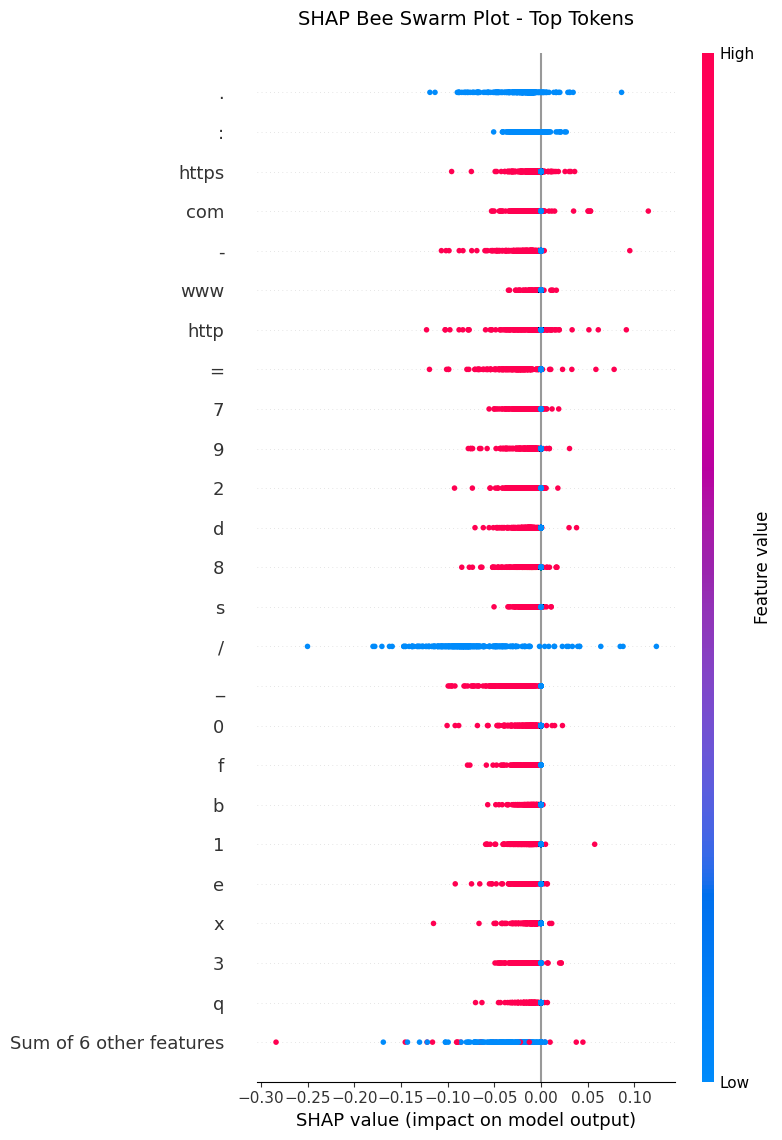

In [ ]:
plt.figure(figsize=(10, 10))
shap.plots.beeswarm(shap_explanation_agg, max_display=25, show=False)
plt.title("SHAP Bee Swarm Plot - Top Tokens", fontsize=14, pad=20)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/DeAnTotNghiep/Explain_Models/PhiUSIIL_Mobile_BERT_SHAP/shap_beeswarm_tokens.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

sample_idx = 55
sample_text = sample_texts[sample_idx]
sample_shap = all_shap_values[sample_idx]

sample_probs = predict_proba_auto([sample_text])[0]
print(f"Class 0 (Phishing): {sample_probs[0]:.6f}")  # ~0.000031
print(f"Class 1 (Benign):   {sample_probs[1]:.6f}")  # ~0.999969

Class 0 (Phishing): 0.001142
Class 1 (Benign):   0.998858


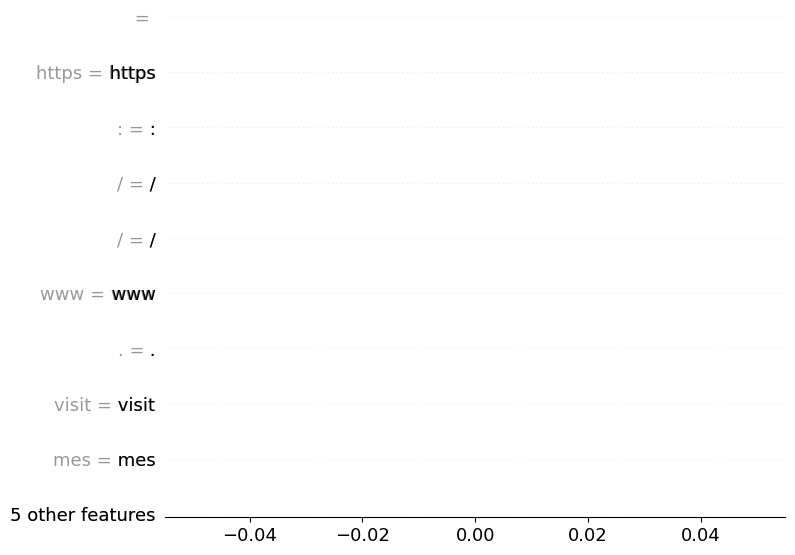

In [ ]:
shap.plots.waterfall(sample_shap[:, 1])

In [ ]:
def plot_top_tokens_bar(shap_values, data, class_idx=1, top_n=15):
    """Vẽ bar plot cho top tokens có impact lớn nhất"""
    values = shap_values[:, class_idx]
    tokens = data

    # Lấy top tokens (both positive and negative)
    abs_values = np.abs(values)
    top_indices = np.argsort(abs_values)[-top_n:][::-1]

    top_tokens = [tokens[i] for i in top_indices]
    top_values = [values[i] for i in top_indices]

    # Vẽ
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['red' if v < 0 else 'blue' for v in top_values]
    bars = ax.barh(range(len(top_tokens)), top_values, color=colors, alpha=0.7)

    ax.set_yticks(range(len(top_tokens)))
    ax.set_yticklabels([f"'{t}'" for t in top_tokens])
    ax.set_xlabel('SHAP Value (Impact on Model Output)', fontsize=11)
    ax.set_title(f'Top {top_n} Tokens by Impact - Sample #{sample_idx}',
                 fontsize=13, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    ax.invert_yaxis()

    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, top_values)):
        ax.text(val, i, f' {val:.4f}', va='center', fontsize=9)

    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/DeAnTotNghiep/Explain_Models/PhiUSIIL_Mobile_BERT_SHAP/sample_{sample_idx}_bar.png", dpi=300, bbox_inches='tight')
    plt.show()

    return top_tokens, top_values

print("\n📊 TOP CONTRIBUTING TOKENS:")
top_tokens, top_values = plot_top_tokens_bar(sample_shap.values, sample_shap.data,
                                              class_idx=1, top_n=15)

In [ ]:
def create_token_analysis_table(shap_values, data, class_idx=1):
    """Tạo bảng phân tích chi tiết từng token"""
    import pandas as pd

    values = shap_values[:, class_idx]
    tokens = data

    # Tạo DataFrame
    analysis_data = []
    for i, (token, value) in enumerate(zip(tokens, values)):
        if token.strip() and token not in ['[PAD]', '[CLS]', '[SEP]']:
            analysis_data.append({
                'Position': i,
                'Token': token,
                'SHAP Value': value,
                'Abs SHAP': abs(value),
                'Impact': 'Push to Benign' if class_idx == 1 else 'Push to Phishing',
                'Strength': '🔴 Strong' if abs(value) > 0.05 else
                           '🟡 Medium' if abs(value) > 0.02 else '🟢 Weak'
            })

    df = pd.DataFrame(analysis_data)
    df = df.sort_values('Abs SHAP', ascending=False)

    return df

print("\n📋 DETAILED TOKEN ANALYSIS TABLE:")
token_df = create_token_analysis_table(sample_shap.values, sample_shap.data, class_idx=1)
print(token_df.head(20).to_string(index=False))

# Lưu full table
token_df.to_csv(f"/content/drive/MyDrive/DeAnTotNghiep/Explain_Models/PhiUSIIL_Mobile_BERT_SHAP/sample_{sample_idx}_token_analysis.csv", index=False)

In [ ]:
def plot_cumulative_impact(shap_values, data, class_idx=1):
    """Vẽ cumulative SHAP values theo position"""
    values = shap_values[:, class_idx]

    # Tính cumulative sum
    cumsum = np.cumsum(values)
    base_value = sample_shap.base_values[class_idx]

    fig, ax = plt.subplots(figsize=(14, 5))

    # Plot cumulative impact
    ax.plot(cumsum, linewidth=2, label='Cumulative SHAP')
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.fill_between(range(len(cumsum)), cumsum, 0, alpha=0.3)

    # Highlight important tokens
    abs_values = np.abs(values)
    top_indices = np.argsort(abs_values)[-10:]

    for idx in top_indices:
        if data[idx].strip():
            ax.scatter(idx, cumsum[idx], s=100, c='red', zorder=5, alpha=0.7)
            ax.annotate(f"'{data[idx]}'",
                       xy=(idx, cumsum[idx]),
                       xytext=(0, 10),
                       textcoords='offset points',
                       ha='center',
                       fontsize=8,
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

    ax.set_xlabel('Token Position', fontsize=11)
    ax.set_ylabel('Cumulative SHAP Value', fontsize=11)
    ax.set_title(f'Cumulative Impact Over Token Sequence - Sample #{sample_idx}',
                 fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/DeAnTotNghiep/Explain_Models/PhiUSIIL_Mobile_BERT_SHAP/sample_{sample_idx}_cumulative.png", dpi=300, bbox_inches='tight')
    plt.show()

print("\n📈 CUMULATIVE IMPACT PLOT:")
plot_cumulative_impact(sample_shap.values, sample_shap.data, class_idx=1)

In [ ]:
def plot_shap_heatmap(shap_values, data, top_n=20):
    """Heatmap so sánh SHAP values giữa 2 classes"""
    # Lấy top tokens theo abs value trung bình
    mean_abs_shap = np.abs(shap_values).mean(axis=1)
    top_indices = np.argsort(mean_abs_shap)[-top_n:][::-1]

    # Tạo ma trận 2 cột (class 0, class 1)
    heatmap_data = shap_values[top_indices, :]
    token_labels = [data[i] if data[i].strip() else f"[pos_{i}]" for i in top_indices]

    fig, ax = plt.subplots(figsize=(8, 10))
    sns.heatmap(heatmap_data,
                annot=True,
                fmt='.3f',
                cmap='RdBu_r',
                center=0,
                cbar_kws={'label': 'SHAP Value'},
                yticklabels=token_labels,
                xticklabels=['Phishing', 'Benign'],
                ax=ax)

    ax.set_title(f'SHAP Values Heatmap - Sample #{sample_idx}',
                 fontsize=13, fontweight='bold')
    ax.set_xlabel('Class', fontsize=11)
    ax.set_ylabel('Token', fontsize=11)

    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/DeAnTotNghiep/Explain_Models/PhiUSIIL_Mobile_BERT_SHAP/sample_{sample_idx}_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()

print("\n🔥 HEATMAP - Both Classes Comparison:")
plot_shap_heatmap(sample_shap.values, sample_shap.data, top_n=20)

In [ ]:
print("\n🛣️ DECISION PLOT - Path from base value to prediction:")

# Decision plot cho benign class (class 1)
shap.decision_plot(
    sample_shap.base_values[1],
    sample_shap.values[:, 1],
    sample_shap.data,
    feature_display_range=slice(-1, -21, -1),  # Top 20 features
    show=False
)
plt.title(f"Decision Plot - Sample #{sample_idx} (Benign Class)", fontsize=12)
plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/DeAnTotNghiep/Explain_Models/PhiUSIIL_Mobile_BERT_SHAP/sample_{sample_idx}_decision.png", dpi=300, bbox_inches='tight')
plt.show()

# Prepare Train/Test for TinyLlama LoRA Fine-Tunning

In [ ]:
df = pd.read_csv("/kaggle/working/PhiUSIIL_final_dataset.csv", sep=";")

# Giảm dataset xuống 50% để chạy nhanh hơn (có thể điều chỉnh)
# Nếu muốn dùng full data, comment dòng dưới
#df = df.sample(frac=0.5, random_state=42).reset_index(drop=True)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df["label_text"] = df["label"].map({0: "phishing", 1: "benign"})

dataset = Dataset.from_pandas(df)
train_test = dataset.train_test_split(test_size=0.1, seed=42)
train_data, val_data = train_test["train"], train_test["test"]

print(f"📊 Training samples: {len(train_data)}")
print(f"📊 Validation samples: {len(val_data)}")

📊 Training samples: 441908
📊 Validation samples: 49101


In [ ]:
print("\n" + "="*50)
print("📊 PHÂN TÍCH CÂN BẰNG NHÃN")
print("="*50)

def check_label_balance(data, data_name):
    """Kiểm tra phân bố nhãn trong dataset"""
    labels = [item['label'] for item in data]

    total = len(labels)
    phishing_count = sum(1 for l in labels if l == 0)
    benign_count = sum(1 for l in labels if l == 1)

    phishing_pct = (phishing_count / total) * 100
    benign_pct = (benign_count / total) * 100

    print(f"\n🔍 {data_name}:")
    print(f"   Total: {total:,} samples")
    print(f"   ├─ Phishing: {phishing_count:,} ({phishing_pct:.2f}%)")
    print(f"   └─ Benign:   {benign_count:,} ({benign_pct:.2f}%)")

    # Tính tỷ lệ imbalance
    ratio = max(phishing_count, benign_count) / min(phishing_count, benign_count)
    print(f"   Imbalance Ratio: 1:{ratio:.2f}")

    if ratio > 1.5:
        print(f"   ⚠️  CẢNH BÁO: Dataset không cân bằng!")
    else:
        print(f"   ✅ Dataset khá cân bằng")

    return phishing_count, benign_count


📊 PHÂN TÍCH CÂN BẰNG NHÃN


In [ ]:
print("\n📁 TOÀN BỘ DATASET:")
total_phishing = sum(1 for l in df['label'] if l == 0)
total_benign = sum(1 for l in df['label'] if l == 1)
print(f"   Total: {len(df):,} samples")
print(f"   ├─ Phishing: {total_phishing:,} ({(total_phishing/len(df))*100:.2f}%)")
print(f"   └─ Benign:   {total_benign:,} ({(total_benign/len(df))*100:.2f}%)")

# Kiểm tra train/val
train_phish, train_benign = check_label_balance(train_data, "TRAIN SET")
val_phish, val_benign = check_label_balance(val_data, "VALIDATION SET")

print("\n" + "="*50)


📁 TOÀN BỘ DATASET:
   Total: 491,009 samples
   ├─ Phishing: 244,332 (49.76%)
   └─ Benign:   246,677 (50.24%)

🔍 TRAIN SET:
   Total: 441,908 samples
   ├─ Phishing: 219,900 (49.76%)
   └─ Benign:   222,008 (50.24%)
   Imbalance Ratio: 1:1.01
   ✅ Dataset khá cân bằng

🔍 VALIDATION SET:
   Total: 49,101 samples
   ├─ Phishing: 24,432 (49.76%)
   └─ Benign:   24,669 (50.24%)
   Imbalance Ratio: 1:1.01
   ✅ Dataset khá cân bằng



In [ ]:
def format_example(example):
    messages = [
        {"role": "system", "content": "You are a cybersecurity assistant that classifies URLs as phishing or benign."},
        {"role": "user", "content": f"Classify the following URL:\n{example['url']}"},
        {"role": "assistant", "content": example["label_text"]},
    ]
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
    return {"text": text}

train_data = train_data.map(format_example, num_proc=4)  # Dùng 4 cores để xử lý song song
val_data = val_data.map(format_example, num_proc=4)

Map (num_proc=4):   0%|          | 0/441908 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/49101 [00:00<?, ? examples/s]

In [ ]:
train_data[:2]

{'url': ['https://www.paradroid.net/cgterm/', 'https://www.aimia.com'],
 'label': [0, 1],
 'label_text': ['phishing', 'benign'],
 'text': ['<|system|>\nYou are a cybersecurity assistant that classifies URLs as phishing or benign.</s>\n<|user|>\nClassify the following URL:\nhttps://www.paradroid.net/cgterm/</s>\n<|assistant|>\nphishing</s>\n',
  '<|system|>\nYou are a cybersecurity assistant that classifies URLs as phishing or benign.</s>\n<|user|>\nClassify the following URL:\nhttps://www.aimia.com</s>\n<|assistant|>\nbenign</s>\n']}

In [ ]:
def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=256,
)

X_train = train_data.map(
    tokenize,
    batched=True,
    remove_columns=["text", "url", "label", "label_text"],
    num_proc=4
)

X_val = val_data.map(
    tokenize,
    batched=True,
    remove_columns=["text", "url", "label", "label_text"],
    num_proc=4
)

Map (num_proc=4):   0%|          | 0/441908 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/49101 [00:00<?, ? examples/s]

In [ ]:
print(X_train[0])

{'input_ids': [1, 529, 29989, 5205, 29989, 29958, 13, 3492, 526, 263, 5094, 495, 8926, 20255, 393, 770, 11057, 24295, 408, 1374, 14424, 470, 3856, 647, 29889, 2, 29871, 13, 29966, 29989, 1792, 29989, 29958, 13, 2385, 1598, 278, 1494, 3988, 29901, 13, 991, 597, 1636, 29889, 862, 328, 1007, 29889, 1212, 29914, 29883, 29887, 8489, 29914, 2, 29871, 13, 29966, 29989, 465, 22137, 29989, 29958, 13, 561, 14424, 2, 29871, 13, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'attention_mask': [1

# Tranning & Evaluation Fine-tined TinyLlama

In [ ]:
training_args = TrainingArguments(
    output_dir=CHECKPOINT_DIR,

    # Batch size & Gradient Accumulation
    per_device_train_batch_size=16,      # Tăng từ 8 -> 16
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,        # Giảm từ 4 -> 2
    # => Effective batch = 16 * 2 * 2 GPU = 64

    # Learning rate & Epochs
    learning_rate=3e-4,                   # Tăng LR để học nhanh hơn
    num_train_epochs=1,
    warmup_ratio=0.03,                    # Warmup 3% steps

    # Optimizer
    optim="adamw_torch_fused",            # Optimizer nhanh hơn

    # Precision
    fp16=True,
    bf16=False,

    # Logging & Checkpointing
    logging_steps=100,                    # Log thường xuyên hơn
    save_steps=500,                       # Lưu checkpoint mỗi 500 steps
    save_total_limit=3,                   # Chỉ giữ 3 checkpoint gần nhất

    # Evaluation
    eval_strategy="no",                   #Tắt eval
    load_best_model_at_end=False,         # Tắt để nhanh hơn

    # Performance
    dataloader_num_workers=4,             # Dùng 4 workers
    dataloader_pin_memory=True,
    gradient_checkpointing=True,          # Giảm memory, tăng tốc

    # Multi-GPU
    ddp_find_unused_parameters=False,

    # Misc
    report_to="none",
    remove_unused_columns=True,

    # Resume
    resume_from_checkpoint=find_latest_checkpoint(CHECKPOINT_DIR) if RESUME_FROM_CHECKPOINT else None,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=X_train,
    eval_dataset=X_val,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

In [ ]:
print("\n" + "="*50)
print("🚀 BẮT ĐẦU TRAINING")
print("="*50)
print(f"✅ Số GPU được sử dụng: {torch.cuda.device_count()}")
print(f"✅ Trainable params: {model.print_trainable_parameters()}")

# Kiểm tra nếu có checkpoint
latest_checkpoint = find_latest_checkpoint(CHECKPOINT_DIR)
if RESUME_FROM_CHECKPOINT and latest_checkpoint:
    print(f"🔄 Tiếp tục từ checkpoint: {latest_checkpoint}")
    trainer.train(resume_from_checkpoint=latest_checkpoint)
else:
    print("🆕 Bắt đầu training mới")
    trainer.train()


🚀 BẮT ĐẦU TRAINING
✅ Số GPU được sử dụng: 2
trainable params: 4,505,600 || all params: 1,104,553,984 || trainable%: 0.4079
✅ Trainable params: None
🔄 Tiếp tục từ checkpoint: ./PhiUSIIL_TinyLlama_LoRA_Checkpoints/checkpoint-13810


Step,Training Loss


In [ ]:
print("\n" + "="*50)
print("🧪 KIỂM TRA MODEL")
print("="*50)

test_urls = [
    "https://lightning.ai/"
]

for url in test_urls:
    messages = [
        {"role": "system", "content": "You are a cybersecurity assistant that classifies URLs as phishing or benign."},
        {"role": "user", "content": f"Classify the following URL:\n{url}"},
    ]

    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_dict=True,
        return_tensors="pt",
    ).to("cuda")

    outputs = model.generate(**inputs, max_new_tokens=10, temperature=0.1)
    result = tokenizer.decode(outputs[0][inputs["input_ids"].shape[-1]:], skip_special_tokens=True)

    print(f"URL: {url}")
    print(f"Prediction: {result}\n")


🧪 KIỂM TRA MODEL
URL: https://lightning.ai/
Prediction: ph < < < < < < < < <

